## Library

In [93]:
import math
import random
import numpy as np
import squigglepy as sq
import matplotlib.pyplot as plt

from copy import copy, deepcopy
from scipy import stats
from pprint import pprint

exec(open('library.py').read())
print('Loaded')

exec(open('/Users/peterhurford/dev/forecastflow/library.py').read()) # TODO: Package
print('Loaded')

Loaded
Loaded


## Anchors (customize these)

In [2]:
def sample_tai_log_flop_needs(brain, efficiency, transformative_vs_human, horizon_length, scaling_exponent,
                              flops_per_param_per_sec, params=None, ref_params=11.2, ref_params_samples=12,
                              bayes_update=None, debug=False):
    # Debug = 1 for just printing parameters
    # Debug = 2 for just printing the equation
    # Debug = True or debug = 3 for printing both
    
    if bayes_update is None:
        bayes_update = lambda x: x
    
    brain_ = sq.sample(brain)
    eff_ = sq.sample(efficiency)
    tvh_ = sq.sample(transformative_vs_human)
    h_ = sq.sample(horizon_length)
    e_ = sq.sample(scaling_exponent)
    fpp_ = sq.sample(flops_per_param_per_sec)
    
    if debug is True or debug == 1 or debug == 2 or debug == 3:
        print('Anchor debug:')
        
    if debug is True or debug == 1 or debug == 3:
        print('-- Assume human brain in inference takes {} log FLOP'.format(round(brain_, 1)))
        print('-- Add {} log FLOP for efficiency'.format(round(eff_, 1)))
        print('-- Assume a transformative model takes {} log FLOP compared to human'.format(round(tvh_, 1)))
        print('-- Assume a horizon length of {}'.format(round(h_, 1)))
        print('-- Assume a scaling exponent of {}'.format(round(e_, 3)))
        print('-- Assume FLOPs per param per sec of {}'.format(round(fpp_, 1)))
    
    if params is None:
        params_ = brain_ + eff_ - fpp_        
    else:
        params_ = sq.sample(params)
    
    out = brain_ + eff_ + tvh_ + h_ + ref_params_samples - e_ * ref_params + e_ * params_
    
    if debug is True or debug == 2 or debug == 3:
        if params is None:
            print(f"-- {round(out, 1)} = {round(brain_, 1)} + {round(eff_, 1)} + {round(tvh_, 1)} + {round(h_, 1)} + {ref_params_samples} - {round(e_, 3)} * {ref_params} + {round(e_, 3)} * ({round(brain_, 1)} + {round(eff_, 1)} - {round(fpp_, 1)})")
        else:
            print(f"-- {round(out, 1)} = {round(brain_, 1)} + {round(eff_, 1)} + {round(tvh_, 1)} + {round(h_, 1)} + {ref_params_samples} - {round(e_, 3)} * {ref_params} + {round(e_, 3)} * {round(params_, 2)}")
    
    out = bayes_update(out)
    if debug is True or debug == 2 or debug == 3:
        print('-- {} after Bayes update'.format(round(out, 1)))
    if debug is True or debug == 1 or debug == 2 or debug == 3:
        print('-')

    return out


def cotra_bayes_update_against_low_flop(f):
    f = f + sq.sample(sq.norm(1,3)) if f < 27 and random.random() > 0.3 else f
    f = f + sq.sample(sq.norm(1,3)) if f < 26 and random.random() > 0.2 else f
    f = f + sq.sample(sq.norm(1,3)) if f < 25 and random.random() > 0.1 else f
    f = f + sq.sample(sq.norm(1,3)) if f < 24 else f
    f = 24 if f < 24 else f
    return f


def sample_cotra_anchor(horizon_length, bayes_update=cotra_bayes_update_against_low_flop, debug=False):
    return sample_tai_log_flop_needs(brain=sq.lognorm(11,19.5),
                                     efficiency=sq.const(1),
                                     transformative_vs_human=sq.norm(-2,2),
                                     horizon_length=horizon_length,
                                     scaling_exponent=sq.norm(0.5,1.1),
                                     flops_per_param_per_sec=sq.norm(1,2),
                                     bayes_update=bayes_update,
                                     debug=debug)

cotra_lifetime_anchor = lambda: sample_tai_log_flop_needs(brain=sq.lognorm(11,19.5),
                                                          efficiency=sq.mixture([sq.lognorm(2,5),
                                                                                 sq.lognorm(5,9)],
                                                                                [0.5,0.5]),
                                                          transformative_vs_human=sq.norm(-2,2),
                                                          horizon_length=sq.const(9),
                                                          scaling_exponent=sq.const(0),
                                                          flops_per_param_per_sec=sq.const(0),
                                                          ref_params_samples=0,
                                                          bayes_update=cotra_bayes_update_against_low_flop)

cotra_gpt_anchor = lambda: sample_cotra_anchor(horizon_length=sq.const(0))
cotra_short_horizon_nn_anchor = lambda: sample_cotra_anchor(horizon_length=sq.norm(0,3))
cotra_medium_horizon_nn_anchor = lambda: sample_cotra_anchor(horizon_length=sq.norm(3,6))
cotra_long_horizon_nn_anchor = lambda: sample_cotra_anchor(horizon_length=sq.norm(6,9))

cotra_genome_anchor = lambda: sample_tai_log_flop_needs(brain=sq.lognorm(11,19.5),
                                                        params=sq.norm(8.3,9.44), # Centered on 8.87... there are ~10^8.7 'params' in genome
                                                        efficiency=sq.norm(0,2),
                                                        transformative_vs_human=sq.norm(-2,2),
                                                        horizon_length=sq.norm(7,9),
                                                        scaling_exponent=sq.norm(0.5,1.1),
                                                        flops_per_param_per_sec=sq.norm(1,2),
                                                        bayes_update=cotra_bayes_update_against_low_flop)

average_ancestor_brain_flops = sq.lognorm(3,6)
log_n_individuals = sq.norm(20,22)
evo_time_log_sec = sq.const(16)
cotra_evolution_anchor = lambda: sample_tai_log_flop_needs(brain=average_ancestor_brain_flops,
                                                           efficiency=sq.norm(-6,5), # TODO: This seems not quite right
                                                           transformative_vs_human=sq.norm(-2,2),
                                                           horizon_length=lambda: (sq.sample(log_n_individuals) +
                                                                                   sq.sample(evo_time_log_sec)),
                                                           scaling_exponent=sq.const(0),
                                                           flops_per_param_per_sec=sq.const(0),
                                                           ref_params_samples=0,
                                                           bayes_update=None)

# A simpler version of Cotra's lifetime anchor that doesn't attempt to adjust for sample efficiency
simple_lifetime_anchor = lambda: sample_tai_log_flop_needs(brain=sq.lognorm(11,19.5),
                                                           efficiency=sq.const(0),
                                                           transformative_vs_human=sq.const(0),
                                                           horizon_length=sq.const(9),
                                                           scaling_exponent=sq.const(0),
                                                           flops_per_param_per_sec=sq.const(0),
                                                           ref_params_samples=0,
                                                           bayes_update=cotra_bayes_update_against_low_flop)

# A simpler version of Cotra's lifetime anchor that doesn't attempt to adjust for sample efficiency OR
# attempt to Bayesian update against low-end FLOP
simple_lifetime_anchor_noup = lambda: sample_tai_log_flop_needs(brain=sq.lognorm(11,19.5),
                                                                efficiency=sq.const(0),
                                                                transformative_vs_human=sq.const(0),
                                                                horizon_length=sq.const(9),
                                                                scaling_exponent=sq.const(0),
                                                                flops_per_param_per_sec=sq.const(0),
                                                                ref_params_samples=0,
                                                                bayes_update=None)

no_path_anchor = sq.lognorm(60,70)

print('Loaded')


Loaded


## Variables (customize these)

In [3]:
# Customize these!!!

# Global variables - probably don't want to change these but you could.
RUNS = 10000                                      # Number of runs to do (default 1000)
CURRENT_YEAR = 2022                               # What year to start the run on? (default: 2022)
MAX_YEAR = 2222                                   # What year to end the run on? (default: 2100)
USE_NUMBERS = 'Wildeford'                         # Which variable set (see below) to use?
GRAPH_P = 50                                      # What percentile to graph on the graphs below? (default: 50)
VARIABLE_SETS = {}


# Cotra (2020)
VARIABLE_SETS['Cotra2020'] = {
    'initial_gdp': 21.3*T, # GDP in `CURRENT_YEAR` of country that will develop TAI (default: 21.3 trillion)
    'tai_flop_size': sq.mixture([cotra_lifetime_anchor,
                                 cotra_short_horizon_nn_anchor,
                                 cotra_genome_anchor,
                                 cotra_medium_horizon_nn_anchor,
                                 cotra_long_horizon_nn_anchor,
                                 cotra_evolution_anchor,
                                 no_path_anchor],
                                [0.052,0.21,0.11,0.312,0.155,0.091,0.07]),
    # 90% CI, it takes 10^X FLOPs to run a transformative AI at inference.
    # Note: A petaflop/s-day (pfs-day) consists of performing 10^15 neural net operations per second for one day,
    # or a total of about 10^20 operations
    'algo_doubling_rate_max': sq.const(3.5),        # 90% CI, algorithms get twice as efficient every X years (maximum)
    'algo_doubling_rate_min': sq.const(2),          # 90% CI, algorithms get twice as efficient every X years (minimum)
    'min_reduction': sq.const(2),                   # 90% CI, the minimum amount of OOMs of reduction in TAI size algorithm improvements could acheive
    'max_reduction': sq.const(5),                   # 90% CI, the maximum amount of OOMs of reduction in TAI size algorithm improvements could acheive
    'initial_flops_per_dollar': sq.const(17),       # 90% CI, as of today, we can buy 10^X FLOPs per $
    'flops_halving_rate': sq.const(2.5),            # 90% CI, the cost of FLOPs per $ halves every X years
    'max_flops_per_dollar': sq.const(24),           # 90% CI, the cheapest FLOPs will get is 10^X FLOPs per $
    'initial_pay': sq.const(8.7),                   # 90% CI, as of today the maximum we would pay for TAI is $10^X
    'gdp_growth': sq.const(1.03),                   # 90% CI, GDP will increase by a factor of X each year
    'max_gdp_frac': sq.const(0.01),                 # 90% CI, the maximum % of GDP that would be spent on TAI is $10^X
    'spend_doubling_time': sq.const(2.5)            # 90% CI, our willingness to spend on TAI doubles every X years
}


VARIABLE_SETS['Cotra2022'] = deepcopy(VARIABLE_SETS['Cotra2020'])
VARIABLE_SETS['Cotra2022']['tai_flop_size'] = sq.mixture([cotra_gpt_anchor,
                                                          cotra_short_horizon_nn_anchor,
                                                          cotra_genome_anchor,
                                                          cotra_medium_horizon_nn_anchor,
                                                          cotra_long_horizon_nn_anchor,
                                                          cotra_evolution_anchor,
                                                          no_path_anchor],
                                                         [0.1,0.33,0.09,0.34,0.04,0.05,0.05])
VARIABLE_SETS['Cotra2022']['initial_flops_per_dollar'] = sq.const(18)


# My variables
def wildeford_bayes_update_against_low_flop(f):
    f = f + sq.sample(sq.norm(1,3)) if f < 27 and sq.event_occurs(p=0.1) else f
    f = f + sq.sample(sq.norm(1,3)) if f < 26 and sq.event_occurs(p=0.2) else f
    f = f + sq.sample(sq.norm(1,3)) if f < 25 and sq.event_occurs(p=0.6) else f
    f = f + sq.sample(sq.norm(1,3)) if f < 24 and sq.event_occurs(p=0.8) else f
    return f

def wildeford_meta_anchor(efficiency, debug=False):
    horizon_length = sq.mixture([sq.const(0),
                                 sq.norm(0,3),
                                 sq.lognorm(3,7),
                                 sq.norm(7,11)],
                                [0.4,0.2,0.25,0.15],
                                lclip=0)
    
    return sample_tai_log_flop_needs(brain=sq.lognorm(11,19.5),
                                     efficiency=efficiency,
                                     transformative_vs_human=sq.norm(-2,1),
                                     horizon_length=horizon_length,
                                     scaling_exponent=sq.norm(0.5,1.5),
                                     flops_per_param_per_sec=sq.norm(1,2),
                                     bayes_update=wildeford_bayes_update_against_low_flop,
                                     debug=debug)

def wildeford_max_gdp_frac():
    small_project = sq.lognorm(0.0002,0.001)
    modern_megaproject = sq.lognorm(0.001,0.002)
    old_form_megaproject = sq.lognorm(0.002,0.006)
    gigaproject = sq.lognorm(0.004,0.02)
    
    r_ = random.random()
    if r_ < 0.1:
        gdp_frac = small_project
        percent_spent_on_compute = sq.lognorm(0.2,0.6, lclip=0.1, rclip=0.9)
    elif r_ < 0.8:
        gdp_frac = modern_megaproject
        percent_spent_on_compute = sq.lognorm(0.4,0.7, lclip=0.1, rclip=0.9)
    elif r_ < 0.95:
        gdp_frac = old_form_megaproject
        percent_spent_on_compute = sq.lognorm(0.5,0.9, lclip=0.1, rclip=0.9)
    else:
        gdp_frac = gigaproject
        percent_spent_on_compute = sq.lognorm(0.6,0.9, lclip=0.1, rclip=0.9)

    return sq.sample(gdp_frac) * sq.sample(percent_spent_on_compute)

VARIABLE_SETS['Wildeford'] = deepcopy(VARIABLE_SETS['Cotra2022'])
VARIABLE_SETS['Wildeford']['tai_flop_size'] = wildeford_meta_anchor
VARIABLE_SETS['Wildeford']['flops_halving_rate'] = sq.lognorm(2, 5)
VARIABLE_SETS['Wildeford']['initial_pay'] = sq.mixture([sq.const(7.1),
                                                        sq.lognorm(7.1,9)],
                                                       [0.8,0.2],
                                                       lclip=7.3) #NEW
VARIABLE_SETS['Wildeford']['gdp_growth'] = sq.lognorm(1.015, 1.035) #NEW
VARIABLE_SETS['Wildeford']['max_gdp_frac'] = wildeford_max_gdp_frac #NEW
VARIABLE_SETS['Wildeford']['spend_doubling_time'] = sq.mixture([sq.lognorm(2,6),
                                                                sq.lognorm(1,2)],
                                                               [0.8,0.2],
                                                               lclip=1) #NEW
# TODO: Willingness to spend connected to commercialization
VARIABLE_SETS['Wildeford']['initial_chance_of_nonscaling_issue'] = 0.9
VARIABLE_SETS['Wildeford']['final_chance_of_nonscaling_issue'] = 0.2 #NEW
VARIABLE_SETS['Wildeford']['nonscaling_issue_bottom_year'] = 2040
VARIABLE_SETS['Wildeford']['nonscaling_delay'] = sq.mixture([sq.lognorm(2,10),
                                                             sq.lognorm(2,35)],
                                                            [0.7,0.3],
                                                            lclip=1) #NEW
VARIABLE_SETS['Wildeford']['algo_doubling_rate_max'] = sq.norm(1,3) # NEW
VARIABLE_SETS['Wildeford']['algo_doubling_rate_min'] = sq.norm(1,2) # NEW
VARIABLE_SETS['Wildeford']['efficiency'] = sq.mixture([sq.const(0),
                                                       sq.lognorm(1,4)],
                                                      [0.1,0.9],
                                                      lclip=0)
VARIABLE_SETS['Wildeford']['use_efficiency_based_algo_reduction'] = True # NEW
VARIABLE_SETS['Wildeford']['efficiency_based_additional_reduction'] = sq.mixture([sq.const(0),
                                                                                  sq.norm(0,2)],
                                                                                 [0.4,0.6],
                                                                                 lclip=0) # NEW


# Kokotajlo (very short timelines, some guesses)
VARIABLE_SETS['Kokotajlo'] = deepcopy(VARIABLE_SETS['Cotra2022'])
VARIABLE_SETS['Kokotajlo']['tai_flop_size'] = sq.lognorm(24, 39)
VARIABLE_SETS['Kokotajlo']['algo_doubling_rate_max'] = sq.const(1)
VARIABLE_SETS['Kokotajlo']['algo_doubling_rate_min'] = sq.const(1)
VARIABLE_SETS['Kokotajlo']['p_willingness_ramp'] = 1
VARIABLE_SETS['Kokotajlo']['willingness_ramp'] = sq.const(0.1)
VARIABLE_SETS['Kokotajlo']['spend_doubling_time'] = sq.const(1)


# These equations define how variables change over time or in relationship to other variables.
def gdp(initial_gdp, gdp_growth, year):
    return initial_gdp * (gdp_growth ** year)


def willingness_to_pay(initial_gdp, gdp_growth, initial_pay, spend_doubling_time, max_gdp_frac, year):
    gdp_ = gdp(initial_gdp=initial_gdp, gdp_growth=gdp_growth, year=year)
    x = (np.log(2) / spend_doubling_time) * year
    if x < 700:
        y = math.log10(initial_pay) + math.log10(math.exp(x)) - math.log10(1 + initial_pay / (gdp_ * max_gdp_frac) * math.exp(x))
        if y > 300:
            y = int(y) # Handle overflow errors
        return 10 ** y
    else: # Handle math.exp and math.log10 overflow errors
        return 10 ** int(math.log10(initial_pay) + (year/spend_doubling_time)/3.3)
    

def algo_halving_fn(min_speed, max_speed, tai_flop_size):
    if max_speed < min_speed:
        max_speed = min_speed
    if min_speed > max_speed:
        min_speed = max_speed
    return min(max(max_speed - (round((tai_flop_size - 29) / 2) / 2), min_speed), max_speed)


def flops_needed(initial_flops, possible_reduction, doubling_rate, year):
    x = (np.log(2) / doubling_rate) * year
    if x < 700:
        y = (math.log10(initial_flops) - max(math.log10(math.exp(x)) - math.log10(1 + (1/possible_reduction) * math.exp(x)), 0))
        if y > 300:
            y = int(y) # Handle overflow errors        
        return 10 ** y
    else: # Handle math.exp and math.log10 overflow errors
        return 10 ** int(math.log10(initial_flops) - (1/possible_reduction))

    
def flops_per_dollar(initial_flops_per_dollar, max_flops_per_dollar, halving_rate, year):
    x = (np.log(2) / halving_rate) * year
    if x < 700:
        y = (math.log10(initial_flops_per_dollar) + math.log10(math.exp(x)) - math.log10(1 + initial_flops_per_dollar / max_flops_per_dollar * math.exp(x)))
        if y > 300:
            y = int(y) # Handle overflow errors                
        return 10 ** y
    else: # Handle math.exp and math.log10 overflow errors
        return 10 ** int(math.log10(initial_flops_per_dollar) + (year/halving_rate)/3.3)

    
def cost_of_tai(initial_flops, possible_reduction, algo_doubling_rate, initial_flops_per_dollar, max_flops_per_dollar,
                flops_halving_rate, year):
    return (flops_needed(initial_flops, possible_reduction, algo_doubling_rate, year) /
            flops_per_dollar(initial_flops_per_dollar, max_flops_per_dollar, flops_halving_rate, year))


def flops_at_max(initial_gdp, gdp_growth, initial_pay, spend_doubling_time, max_gdp_frac,
                 initial_flops_per_dollar, max_flops_per_dollar, flops_halving_rate, year):
    return (willingness_to_pay(initial_gdp=initial_gdp,
                               gdp_growth=gdp_growth,
                               initial_pay=initial_pay,
                               spend_doubling_time=spend_doubling_time,
                               max_gdp_frac=0.01,
                               year=year) *
            flops_per_dollar(initial_flops_per_dollar, max_flops_per_dollar, flops_halving_rate, year))


def possible_algo_reduction_fn(min_reduction, max_reduction, tai_flop_size):
    if max_reduction < min_reduction:
        max_reduction = min_reduction
    if min_reduction > max_reduction:
        min_reduction = max_reduction
    return min(max(min_reduction + round((tai_flop_size - 32) / 4), min_reduction), max_reduction)


# NEW
def p_nonscaling_delay(initial_p, final_p, year, max_year):
    return generalized_logistic_curve(x=year - CURRENT_YEAR,
                                      slope=0.3,
                                      shift=3 * (max_year - CURRENT_YEAR),
                                      push=1,
                                      maximum=final_p,
                                      minimum=initial_p)
    

# ------------- Ignore below here ------------
years = list(range(CURRENT_YEAR, MAX_YEAR))
variables = VARIABLE_SETS[USE_NUMBERS]
print('Loaded')


Loaded


{1: 24.311813625003527,
 5: 26.068896662188347,
 10: 27.27396279304332,
 20: 29.472841015790085,
 30: 31.392756071007557,
 40: 33.08274605176356,
 50: 34.78630982151783,
 60: 36.42256309395411,
 70: 38.39242465015582,
 80: 40.74579476909198,
 90: 44.36900531937253,
 95: 47.41584194039991,
 99: 53.71953875953279}


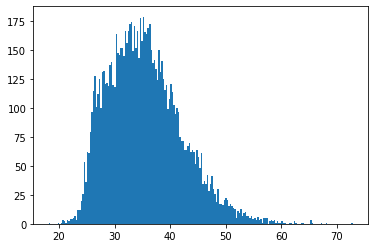

In [4]:
if variables.get('use_efficiency_based_algo_reduction'):
    initial_flop_size_s = sq.sample(lambda: variables['tai_flop_size'](variables['efficiency']), n=10000)
else:
    initial_flop_size_s = sq.sample(variables['tai_flop_size'], n=10000)

initial_flops_p = sq.get_percentiles(initial_flop_size_s)
plt.hist(initial_flop_size_s, bins = 200)
pprint(initial_flops_p)

In [5]:
min_reduction_p = sq.get_percentiles(sq.sample(variables['min_reduction'], n=1000))
min_reduction_p

{1: 2.0,
 5: 2.0,
 10: 2.0,
 20: 2.0,
 30: 2.0,
 40: 2.0,
 50: 2.0,
 60: 2.0,
 70: 2.0,
 80: 2.0,
 90: 2.0,
 95: 2.0,
 99: 2.0}

In [6]:
max_reduction_p = sq.get_percentiles(sq.sample(variables['max_reduction'], n=1000), reverse=True)
max_reduction_p

{99: 5.0,
 95: 5.0,
 90: 5.0,
 80: 5.0,
 70: 5.0,
 60: 5.0,
 50: 5.0,
 40: 5.0,
 30: 5.0,
 20: 5.0,
 10: 5.0,
 5: 5.0,
 1: 5.0}

In [7]:
algo_doubling_rate_min_p = sq.get_percentiles(sq.sample(variables['algo_doubling_rate_min'], n=1000), reverse=True)
algo_doubling_rate_min_p

{99: 0.8357609093866101,
 95: 0.9969705482378397,
 90: 1.095907988031746,
 80: 1.2391332902954069,
 70: 1.3476086543893275,
 60: 1.4300721219148214,
 50: 1.4982725233428544,
 40: 1.5851041252766613,
 30: 1.6747724413354685,
 20: 1.7852052954706823,
 10: 1.897323359899033,
 5: 2.0016134647901596,
 1: 2.189339957027911}

In [8]:
algo_doubling_rate_max_p = sq.get_percentiles(sq.sample(variables['algo_doubling_rate_max'], n=1000), reverse=True)
algo_doubling_rate_max_p

{99: 0.6577570643365872,
 95: 1.0864992238790234,
 90: 1.2488278362406544,
 80: 1.5058847058655935,
 70: 1.7103109948697013,
 60: 1.8773337865241548,
 50: 2.0345211681477355,
 40: 2.2201287486030807,
 30: 2.3677982596187324,
 20: 2.551057607864028,
 10: 2.7501316757933885,
 5: 2.940086347059822,
 1: 3.479611574043985}

In [9]:
initial_flops_per_dollar_p = sq.get_percentiles(sq.sample(variables['initial_flops_per_dollar'], n=1000))
initial_flops_per_dollar_p

{1: 18.0,
 5: 18.0,
 10: 18.0,
 20: 18.0,
 30: 18.0,
 40: 18.0,
 50: 18.0,
 60: 18.0,
 70: 18.0,
 80: 18.0,
 90: 18.0,
 95: 18.0,
 99: 18.0}

In [10]:
flops_halving_rate_p = sq.get_percentiles(sq.sample(variables['flops_halving_rate'], n=1000), reverse=True)
flops_halving_rate_p

{99: 1.7230386669557713,
 95: 2.0019157682554134,
 90: 2.183635773657993,
 80: 2.47134127785195,
 70: 2.6926285328120514,
 60: 2.898942511136372,
 50: 3.1051733202621623,
 40: 3.316167573444333,
 30: 3.628911340446479,
 20: 3.963345073197226,
 10: 4.4747449098856915,
 5: 4.848631780718377,
 1: 5.873086020731033}

In [11]:
max_flops_per_dollar_p = sq.get_percentiles(sq.sample(variables['max_flops_per_dollar'], n=1000))
max_flops_per_dollar_p

{1: 24.0,
 5: 24.0,
 10: 24.0,
 20: 24.0,
 30: 24.0,
 40: 24.0,
 50: 24.0,
 60: 24.0,
 70: 24.0,
 80: 24.0,
 90: 24.0,
 95: 24.0,
 99: 24.0}

In [12]:
initial_pay_p = sq.get_percentiles(sq.sample(variables['initial_pay'], n=1000))
initial_pay_p

{1: 7.3,
 5: 7.3,
 10: 7.3,
 20: 7.3,
 30: 7.3,
 40: 7.3,
 50: 7.3,
 60: 7.3,
 70: 7.3,
 80: 7.3,
 90: 8.02718196311028,
 95: 8.337551979282058,
 99: 8.949417962363519}

In [13]:
gdp_growth_p = sq.get_percentiles(sq.sample(variables['gdp_growth'], n=1000))
gdp_growth_p

{1: 1.011670706208486,
 5: 1.0150968113900587,
 10: 1.0171615657232647,
 20: 1.0196304126334732,
 30: 1.0218924868236774,
 40: 1.0234970894519806,
 50: 1.0250013568369631,
 60: 1.0262789932449365,
 70: 1.028163927656075,
 80: 1.0300573255024907,
 90: 1.0328105655135507,
 95: 1.0348558783378219,
 99: 1.039093921645907}

In [14]:
max_gdp_frac_p = sq.get_percentiles(sq.sample(variables['max_gdp_frac'], n=1000))
max_gdp_frac_p

{1: 6.984592648922233e-05,
 5: 0.00012122633863893426,
 10: 0.00025544788466350967,
 20: 0.0005266234747300244,
 30: 0.0006220364064220432,
 40: 0.0007013391538423119,
 50: 0.0007863405930590122,
 60: 0.0008630478898530083,
 70: 0.0009944430828584577,
 80: 0.0013010149239042273,
 90: 0.0026511364481362817,
 95: 0.0036073828904775074,
 99: 0.008154775397767471}

In [15]:
willingness_ramp = variables.get('willingness_ramp', 0)
if willingness_ramp != 0:
    willingness_ramp_p = sq.get_percentiles(sq.sample(willingness_ramp), n=1000)
    pprint(willingness_ramp_p)
else:
    print(0)

0


In [16]:
spend_doubling_time_p = sq.get_percentiles(sq.sample(variables['spend_doubling_time'], n=1000), reverse=True)
spend_doubling_time_p

{99: 1.0,
 95: 1.2494473470335214,
 90: 1.4346027347224108,
 80: 1.8786901549012072,
 70: 2.422839952885939,
 60: 2.8576524349984176,
 50: 3.195341636668977,
 40: 3.520857505912042,
 30: 3.9338922814130997,
 20: 4.368180054482436,
 10: 5.129094634197641,
 5: 5.81012514622703,
 1: 7.024069346595851}

In [17]:
nonscaling_delay = variables.get('nonscaling_delay', 0)
if nonscaling_delay != 0:
    nonscaling_delay_p = sq.get_percentiles(np.ceil(sq.sample(nonscaling_delay, n=1000)), reverse=True)
    pprint(nonscaling_delay_p)
else:
    print(0)

{1: 33.0,
 5: 18.0,
 10: 13.0,
 20: 9.0,
 30: 7.0,
 40: 6.0,
 50: 5.0,
 60: 5.0,
 70: 4.0,
 80: 4.0,
 90: 3.0,
 95: 3.0,
 99: 2.0}


In [18]:
willingness_spend_horizon = variables.get('willingness_spend_horizon', 1)
if willingness_spend_horizon != 1:
    willingness_spend_horizon_p = sq.get_percentiles(sq.sample(willingness_spend_horizon, n=1000))
    pprint(willingness_spend_horizon_p)
else:
    print(1)

1


## GDP Over Time

Text(0, 0.5, 'log GDP')

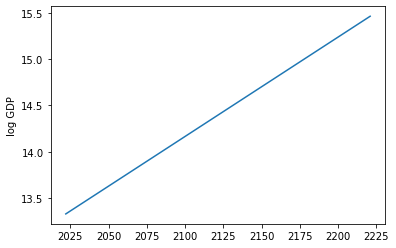

In [19]:
gdp_ = np.array([gdp(initial_gdp=variables['initial_gdp'],
                     gdp_growth=gdp_growth_p[GRAPH_P],
                     year=(y - CURRENT_YEAR)) for y in years])
plt.plot(years, np.log10(gdp_))
plt.ylabel('log GDP')

In [20]:
for y in years:
    print('Year: {} - GDP log 2022$USD {} (~{})'.format(y,
                                                        np.round(np.log10(gdp_[y - CURRENT_YEAR]), 1),
                                                        sq.numerize(np.log10(gdp_[y - CURRENT_YEAR]))))
    

Year: 2022 - GDP log 2022$USD 13.3 (~10 trillion)
Year: 2023 - GDP log 2022$USD 13.3 (~10 trillion)
Year: 2024 - GDP log 2022$USD 13.3 (~10 trillion)
Year: 2025 - GDP log 2022$USD 13.4 (~10 trillion)
Year: 2026 - GDP log 2022$USD 13.4 (~10 trillion)
Year: 2027 - GDP log 2022$USD 13.4 (~10 trillion)
Year: 2028 - GDP log 2022$USD 13.4 (~10 trillion)
Year: 2029 - GDP log 2022$USD 13.4 (~10 trillion)
Year: 2030 - GDP log 2022$USD 13.4 (~10 trillion)
Year: 2031 - GDP log 2022$USD 13.4 (~10 trillion)
Year: 2032 - GDP log 2022$USD 13.4 (~10 trillion)
Year: 2033 - GDP log 2022$USD 13.4 (~10 trillion)
Year: 2034 - GDP log 2022$USD 13.5 (~10 trillion)
Year: 2035 - GDP log 2022$USD 13.5 (~10 trillion)
Year: 2036 - GDP log 2022$USD 13.5 (~10 trillion)
Year: 2037 - GDP log 2022$USD 13.5 (~10 trillion)
Year: 2038 - GDP log 2022$USD 13.5 (~10 trillion)
Year: 2039 - GDP log 2022$USD 13.5 (~10 trillion)
Year: 2040 - GDP log 2022$USD 13.5 (~10 trillion)
Year: 2041 - GDP log 2022$USD 13.5 (~10 trillion)


## Willingness to Pay Over Time

-
-
## 20 ##
Year: 2022 - willingness log 2022$USD per year 7.3 (~10 million)
Year: 2023 - willingness log 2022$USD per year 7.4 (~10 million)
Year: 2024 - willingness log 2022$USD per year 7.4 (~10 million)
Year: 2025 - willingness log 2022$USD per year 7.5 (~10 million)
Year: 2026 - willingness log 2022$USD per year 7.6 (~10 million)
Year: 2027 - willingness log 2022$USD per year 7.6 (~10 million)
Year: 2028 - willingness log 2022$USD per year 7.7 (~10 million)
Year: 2029 - willingness log 2022$USD per year 7.8 (~10 million)
Year: 2030 - willingness log 2022$USD per year 7.8 (~10 million)
Year: 2031 - willingness log 2022$USD per year 7.9 (~10 million)
Year: 2032 - willingness log 2022$USD per year 8.0 (~10 million)
Year: 2033 - willingness log 2022$USD per year 8.1 (~100 million)
Year: 2034 - willingness log 2022$USD per year 8.1 (~100 million)
Year: 2035 - willingness log 2022$USD per year 8.2 (~100 million)
Year: 2036 - willingness log 2022$USD per year 8.3 (~100 million)
Year: 20

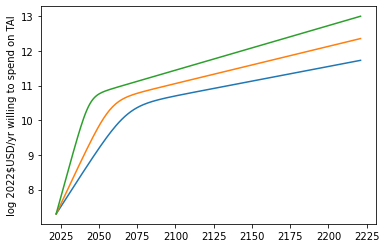

In [21]:
for p in [20, 50, 80]:
    print('-')
    print('-')
    print('## {} ##'.format(p))
    willingness = np.array([willingness_to_pay(initial_gdp=variables['initial_gdp'],
                                               gdp_growth=gdp_growth_p[p],
                                               initial_pay=10 ** initial_pay_p[p],
                                               spend_doubling_time=spend_doubling_time_p[p],
                                               max_gdp_frac=max_gdp_frac_p[p],
                                               year=(y - CURRENT_YEAR)) for y in years])
    for y in years:
        print('Year: {} - willingness log 2022$USD per year {} (~{})'.format(y,
                                                                             np.round(np.log10(willingness[y - CURRENT_YEAR]), 1),
                                                                             sq.numerize(np.log10(willingness[y - CURRENT_YEAR]))))


    plt.plot(years, np.log10(willingness))
plt.ylabel('log 2022$USD/yr willing to spend on TAI')
plt.show()


## FLOPs Needed to Make TAI (Given Algorithmic Progress)

Text(0, 0.5, 'log FLOPs needed to make TAI')

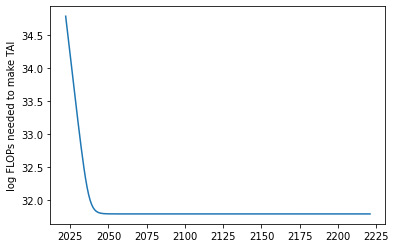

In [22]:
flops_ = np.array([flops_needed(initial_flops=10 ** initial_flops_p[GRAPH_P],
                                doubling_rate=algo_halving_fn(algo_doubling_rate_min_p[GRAPH_P],
                                                              algo_doubling_rate_max_p[GRAPH_P],
                                                              initial_flops_p[GRAPH_P]),
                                possible_reduction=10 ** possible_algo_reduction_fn(min_reduction_p[GRAPH_P],
                                                                                    max_reduction_p[GRAPH_P],
                                                                                    initial_flops_p[GRAPH_P]),
                                year=(y - CURRENT_YEAR)) for y in years])

plt.plot(years, np.log10(flops_))
plt.ylabel('log FLOPs needed to make TAI')


In [23]:
for y in years:
    print('Year: {} - log FLOPs needed for TAI {} (~{})'.format(y,
                                                                np.round(np.log10(flops_[y - CURRENT_YEAR]), 1),
                                                                sq.numerize(np.log10(flops_[y - CURRENT_YEAR]))))

Year: 2022 - log FLOPs needed for TAI 34.8 (~10 decillion)
Year: 2023 - log FLOPs needed for TAI 34.6 (~10 decillion)
Year: 2024 - log FLOPs needed for TAI 34.4 (~10 decillion)
Year: 2025 - log FLOPs needed for TAI 34.2 (~10 decillion)
Year: 2026 - log FLOPs needed for TAI 34.0 (~one decillion)
Year: 2027 - log FLOPs needed for TAI 33.8 (~one decillion)
Year: 2028 - log FLOPs needed for TAI 33.6 (~one decillion)
Year: 2029 - log FLOPs needed for TAI 33.4 (~one decillion)
Year: 2030 - log FLOPs needed for TAI 33.2 (~one decillion)
Year: 2031 - log FLOPs needed for TAI 33.0 (~one decillion)
Year: 2032 - log FLOPs needed for TAI 32.8 (~100 nonillion)
Year: 2033 - log FLOPs needed for TAI 32.6 (~100 nonillion)
Year: 2034 - log FLOPs needed for TAI 32.5 (~100 nonillion)
Year: 2035 - log FLOPs needed for TAI 32.3 (~100 nonillion)
Year: 2036 - log FLOPs needed for TAI 32.2 (~100 nonillion)
Year: 2037 - log FLOPs needed for TAI 32.1 (~100 nonillion)
Year: 2038 - log FLOPs needed for TAI 32.0 (

## FLOPs per Dollar (Given Declining Costs)

Text(0, 0.5, 'log FLOPs per $1')

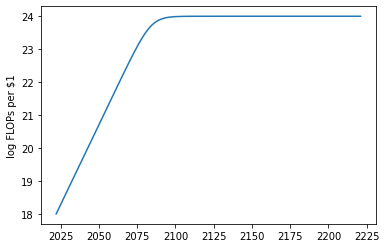

In [24]:
flops_per_dollar_ = np.array([flops_per_dollar(initial_flops_per_dollar=10 ** initial_flops_per_dollar_p[GRAPH_P],
                                               max_flops_per_dollar=10 ** max_flops_per_dollar_p[GRAPH_P],
                                               halving_rate=flops_halving_rate_p[GRAPH_P],
                                               year=(y - CURRENT_YEAR)) for y in years])
plt.plot(years, np.log10(flops_per_dollar_))
plt.ylabel('log FLOPs per $1')


In [25]:
for y in years:
    print('Year: {} - log {} FLOPs per $ (~{})'.format(y,
                                                       np.round(np.log10(flops_per_dollar_[y - CURRENT_YEAR]), 1),
                                                       sq.numerize(np.log10(flops_per_dollar_[y - CURRENT_YEAR]))))

Year: 2022 - log 18.0 FLOPs per $ (~100 quadrillion)
Year: 2023 - log 18.1 FLOPs per $ (~one quintillion)
Year: 2024 - log 18.2 FLOPs per $ (~one quintillion)
Year: 2025 - log 18.3 FLOPs per $ (~one quintillion)
Year: 2026 - log 18.4 FLOPs per $ (~one quintillion)
Year: 2027 - log 18.5 FLOPs per $ (~one quintillion)
Year: 2028 - log 18.6 FLOPs per $ (~one quintillion)
Year: 2029 - log 18.7 FLOPs per $ (~one quintillion)
Year: 2030 - log 18.8 FLOPs per $ (~one quintillion)
Year: 2031 - log 18.9 FLOPs per $ (~one quintillion)
Year: 2032 - log 19.0 FLOPs per $ (~one quintillion)
Year: 2033 - log 19.1 FLOPs per $ (~10 quintillion)
Year: 2034 - log 19.2 FLOPs per $ (~10 quintillion)
Year: 2035 - log 19.3 FLOPs per $ (~10 quintillion)
Year: 2036 - log 19.4 FLOPs per $ (~10 quintillion)
Year: 2037 - log 19.5 FLOPs per $ (~10 quintillion)
Year: 2038 - log 19.6 FLOPs per $ (~10 quintillion)
Year: 2039 - log 19.6 FLOPs per $ (~10 quintillion)
Year: 2040 - log 19.7 FLOPs per $ (~10 quintillion)
Y

## Max Possible OOM Reduction in TAI FLOP Size

Text(0.5, 0, 'initial FLOP needed for TAI prior to any reduction')

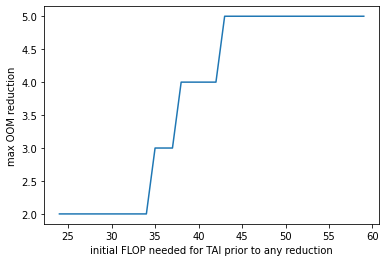

In [26]:
# TODO: Update to include efficiency based
tai_sizes = range(24, 60)
flops_per_dollar_ = np.array([possible_algo_reduction_fn(min_reduction_p[GRAPH_P],
                                                         max_reduction_p[GRAPH_P], t) for t in tai_sizes])
plt.plot(tai_sizes, flops_per_dollar_)
plt.ylabel('max OOM reduction')
plt.xlabel('initial FLOP needed for TAI prior to any reduction')


In [27]:
for t in tai_sizes:
    print('TAI log FLOP {} -> {} OOM reductions possible'.format(t,
                                                                 round(possible_algo_reduction_fn(min_reduction_p[GRAPH_P],
                                                                                                  max_reduction_p[GRAPH_P],
                                                                                                  t), 2)))
          

TAI log FLOP 24 -> 2.0 OOM reductions possible
TAI log FLOP 25 -> 2.0 OOM reductions possible
TAI log FLOP 26 -> 2.0 OOM reductions possible
TAI log FLOP 27 -> 2.0 OOM reductions possible
TAI log FLOP 28 -> 2.0 OOM reductions possible
TAI log FLOP 29 -> 2.0 OOM reductions possible
TAI log FLOP 30 -> 2.0 OOM reductions possible
TAI log FLOP 31 -> 2.0 OOM reductions possible
TAI log FLOP 32 -> 2.0 OOM reductions possible
TAI log FLOP 33 -> 2.0 OOM reductions possible
TAI log FLOP 34 -> 2.0 OOM reductions possible
TAI log FLOP 35 -> 3.0 OOM reductions possible
TAI log FLOP 36 -> 3.0 OOM reductions possible
TAI log FLOP 37 -> 3.0 OOM reductions possible
TAI log FLOP 38 -> 4.0 OOM reductions possible
TAI log FLOP 39 -> 4.0 OOM reductions possible
TAI log FLOP 40 -> 4.0 OOM reductions possible
TAI log FLOP 41 -> 4.0 OOM reductions possible
TAI log FLOP 42 -> 4.0 OOM reductions possible
TAI log FLOP 43 -> 5.0 OOM reductions possible
TAI log FLOP 44 -> 5.0 OOM reductions possible
TAI log FLOP 

## Halving time (years) of compute requirements

Text(0.5, 0, 'initial FLOP needed for TAI prior to any reduction')

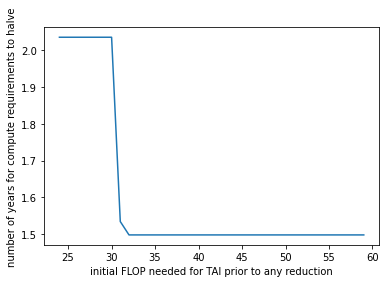

In [28]:
tai_sizes = range(24, 60)
flops_per_dollar_ = np.array([algo_halving_fn(algo_doubling_rate_min_p[GRAPH_P],
                                              algo_doubling_rate_max_p[GRAPH_P],
                                              t) for t in tai_sizes])
plt.plot(tai_sizes, flops_per_dollar_)
plt.ylabel('number of years for compute requirements to halve')
plt.xlabel('initial FLOP needed for TAI prior to any reduction')


In [29]:
for t in tai_sizes:
    print('TAI log FLOP {} -> algo doubling rate {}yrs'.format(t,
                                                               round(algo_halving_fn(algo_doubling_rate_min_p[GRAPH_P],
                                                                                     algo_doubling_rate_max_p[GRAPH_P],
                                                                                     t), 2)))


TAI log FLOP 24 -> algo doubling rate 2.03yrs
TAI log FLOP 25 -> algo doubling rate 2.03yrs
TAI log FLOP 26 -> algo doubling rate 2.03yrs
TAI log FLOP 27 -> algo doubling rate 2.03yrs
TAI log FLOP 28 -> algo doubling rate 2.03yrs
TAI log FLOP 29 -> algo doubling rate 2.03yrs
TAI log FLOP 30 -> algo doubling rate 2.03yrs
TAI log FLOP 31 -> algo doubling rate 1.53yrs
TAI log FLOP 32 -> algo doubling rate 1.5yrs
TAI log FLOP 33 -> algo doubling rate 1.5yrs
TAI log FLOP 34 -> algo doubling rate 1.5yrs
TAI log FLOP 35 -> algo doubling rate 1.5yrs
TAI log FLOP 36 -> algo doubling rate 1.5yrs
TAI log FLOP 37 -> algo doubling rate 1.5yrs
TAI log FLOP 38 -> algo doubling rate 1.5yrs
TAI log FLOP 39 -> algo doubling rate 1.5yrs
TAI log FLOP 40 -> algo doubling rate 1.5yrs
TAI log FLOP 41 -> algo doubling rate 1.5yrs
TAI log FLOP 42 -> algo doubling rate 1.5yrs
TAI log FLOP 43 -> algo doubling rate 1.5yrs
TAI log FLOP 44 -> algo doubling rate 1.5yrs
TAI log FLOP 45 -> algo doubling rate 1.5yrs
TA

## Dollars Needed to Buy TAI (Given Algorithmic Progress and Decline in Cost per FLOP)

Text(0, 0.5, 'log $ needed to buy TAI')

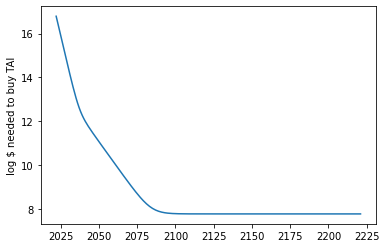

In [30]:
cost_of_tai_ = np.array([cost_of_tai(initial_flops=10 ** initial_flops_p[GRAPH_P],
                                     possible_reduction=10 ** possible_algo_reduction_fn(min_reduction_p[GRAPH_P], max_reduction_p[GRAPH_P], initial_flops_p[GRAPH_P]),
                                     algo_doubling_rate=algo_halving_fn(algo_doubling_rate_min_p[GRAPH_P],
                                                                        algo_doubling_rate_max_p[GRAPH_P],
                                                                        initial_flops_p[GRAPH_P]),
                                     initial_flops_per_dollar=10 ** initial_flops_per_dollar_p[GRAPH_P],
                                     max_flops_per_dollar=10 ** max_flops_per_dollar_p[GRAPH_P],
                                     flops_halving_rate=flops_halving_rate_p[GRAPH_P],
                                     year=(y - CURRENT_YEAR)) for y in years])

plt.plot(years, np.log10(cost_of_tai_))
plt.ylabel('log $ needed to buy TAI')


In [31]:
for y in years:
    print('Year: {} - log $ {} to buy TAI (~{})'.format(y,
                                                        np.round(np.log10(cost_of_tai_[y - CURRENT_YEAR]), 1),
                                                        sq.numerize(np.log10(cost_of_tai_[y - CURRENT_YEAR]))))

Year: 2022 - log $ 16.8 to buy TAI (~10 quadrillion)
Year: 2023 - log $ 16.5 to buy TAI (~10 quadrillion)
Year: 2024 - log $ 16.2 to buy TAI (~10 quadrillion)
Year: 2025 - log $ 15.9 to buy TAI (~one quadrillion)
Year: 2026 - log $ 15.6 to buy TAI (~one quadrillion)
Year: 2027 - log $ 15.3 to buy TAI (~one quadrillion)
Year: 2028 - log $ 15.0 to buy TAI (~one quadrillion)
Year: 2029 - log $ 14.7 to buy TAI (~100 trillion)
Year: 2030 - log $ 14.4 to buy TAI (~100 trillion)
Year: 2031 - log $ 14.1 to buy TAI (~100 trillion)
Year: 2032 - log $ 13.8 to buy TAI (~10 trillion)
Year: 2033 - log $ 13.6 to buy TAI (~10 trillion)
Year: 2034 - log $ 13.3 to buy TAI (~10 trillion)
Year: 2035 - log $ 13.1 to buy TAI (~10 trillion)
Year: 2036 - log $ 12.8 to buy TAI (~one trillion)
Year: 2037 - log $ 12.6 to buy TAI (~one trillion)
Year: 2038 - log $ 12.4 to buy TAI (~one trillion)
Year: 2039 - log $ 12.3 to buy TAI (~one trillion)
Year: 2040 - log $ 12.1 to buy TAI (~one trillion)
Year: 2041 - log 

## FLOPs at Max Spend

Text(0, 0.5, 'max log FLOPs bought given willingness to spend')

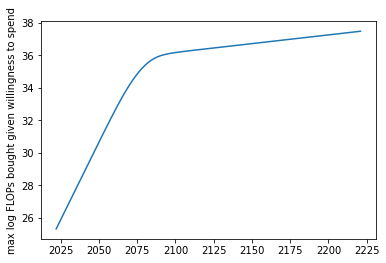

In [32]:
flops_at_max_ = np.array([flops_at_max(initial_gdp=variables['initial_gdp'],
                                       gdp_growth=gdp_growth_p[GRAPH_P],
                                       initial_pay=10 ** initial_pay_p[GRAPH_P],
                                       spend_doubling_time=spend_doubling_time_p[GRAPH_P],
                                       max_gdp_frac=max_gdp_frac_p[GRAPH_P],
                                       initial_flops_per_dollar=10 ** initial_flops_per_dollar_p[GRAPH_P],
                                       max_flops_per_dollar=10 ** max_flops_per_dollar_p[GRAPH_P],
                                       flops_halving_rate=flops_halving_rate_p[GRAPH_P],
                                       year=(y - CURRENT_YEAR)) for y in years])

plt.plot(years, np.log10(flops_at_max_))
plt.ylabel('max log FLOPs bought given willingness to spend')


In [74]:
for y in years:
    print('Year: {} - max log FLOPs {} (~{} FLOP, ~{} petaFLOP/s-days)'.format(y,
                                                                               np.round(np.log10(flops_at_max_[y - CURRENT_YEAR]), 1),
                                                                               sq.numerize(np.log10(flops_at_max_[y - CURRENT_YEAR])),
                                                                               log_flop_to_petaflop_sdays(np.log10(flops_at_max_[y - CURRENT_YEAR]))))
    

Year: 2022 - max log FLOPs 25.3 (~10 septillion FLOP, ~230911 petaFLOP/s-days)
Year: 2023 - max log FLOPs 25.5 (~10 septillion FLOP, ~358583 petaFLOP/s-days)
Year: 2024 - max log FLOPs 25.7 (~10 septillion FLOP, ~556844 petaFLOP/s-days)
Year: 2025 - max log FLOPs 25.9 (~10 septillion FLOP, ~864717 petaFLOP/s-days)
Year: 2026 - max log FLOPs 26.1 (~100 septillion FLOP, ~1342803 petaFLOP/s-days)
Year: 2027 - max log FLOPs 26.3 (~100 septillion FLOP, ~2085197 petaFLOP/s-days)
Year: 2028 - max log FLOPs 26.4 (~100 septillion FLOP, ~3238007 petaFLOP/s-days)
Year: 2029 - max log FLOPs 26.6 (~100 septillion FLOP, ~5028098 petaFLOP/s-days)
Year: 2030 - max log FLOPs 26.8 (~100 septillion FLOP, ~7807713 petaFLOP/s-days)
Year: 2031 - max log FLOPs 27.0 (~one octillion FLOP, ~12123744 petaFLOP/s-days)
Year: 2032 - max log FLOPs 27.2 (~one octillion FLOP, ~18825261 petaFLOP/s-days)
Year: 2033 - max log FLOPs 27.4 (~one octillion FLOP, ~29230402 petaFLOP/s-days)
Year: 2034 - max log FLOPs 27.6 (~on

## Chance of Non-scaling Delay

Text(0, 0.5, 'chance of non-scaling delay by year')

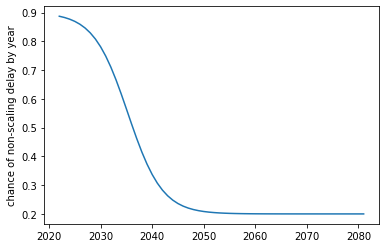

In [34]:
p_nonscaling_delay_ = np.array([p_nonscaling_delay(variables.get('initial_chance_of_nonscaling_issue', 0),
                                                   variables.get('final_chance_of_nonscaling_issue', 0),
                                                   year=y,
                                                   max_year=variables.get('nonscaling_issue_bottom_year', 0)) for y in years])

plt.plot(years[:60], p_nonscaling_delay_[:60])
plt.ylabel('chance of non-scaling delay by year')


In [35]:
for y in years:
    print('Year: {} - p(nonscaling delay) = {}%'.format(y,
                                                        np.round(p_nonscaling_delay_[y - CURRENT_YEAR] * 100, 1)))

Year: 2022 - p(nonscaling delay) = 88.7%
Year: 2023 - p(nonscaling delay) = 88.3%
Year: 2024 - p(nonscaling delay) = 87.7%
Year: 2025 - p(nonscaling delay) = 87.0%
Year: 2026 - p(nonscaling delay) = 85.9%
Year: 2027 - p(nonscaling delay) = 84.6%
Year: 2028 - p(nonscaling delay) = 82.9%
Year: 2029 - p(nonscaling delay) = 80.8%
Year: 2030 - p(nonscaling delay) = 78.1%
Year: 2031 - p(nonscaling delay) = 74.9%
Year: 2032 - p(nonscaling delay) = 71.0%
Year: 2033 - p(nonscaling delay) = 66.6%
Year: 2034 - p(nonscaling delay) = 61.7%
Year: 2035 - p(nonscaling delay) = 56.6%
Year: 2036 - p(nonscaling delay) = 51.3%
Year: 2037 - p(nonscaling delay) = 46.2%
Year: 2038 - p(nonscaling delay) = 41.5%
Year: 2039 - p(nonscaling delay) = 37.3%
Year: 2040 - p(nonscaling delay) = 33.7%
Year: 2041 - p(nonscaling delay) = 30.7%
Year: 2042 - p(nonscaling delay) = 28.3%
Year: 2043 - p(nonscaling delay) = 26.3%
Year: 2044 - p(nonscaling delay) = 24.8%
Year: 2045 - p(nonscaling delay) = 23.6%
Year: 2046 - p(n

## Run Model

It takes 31 log FLOPs (~10 nonillion) for transformative capabilities.
Every 2 years algorithms get 2x better, with 3 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~one quintillion) per 2022$USD. Every 2 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 7.0 log 2022$USD (~10 million) and this increases by 3x per year to a max of 0.0005% of GDP. GDP grows at a rate of 1.025x per year.
We are willing to spend over 10 years to make TAI
If a non-scaling delay happens, it will take an additional 6 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 25.0 max log FLOP (one septillion) available - TAI takes 31.0 log FLOP (10 nonillion) - log $ 13.0 to buy TAI (10 trillion) vs. willingness to pay log $ 7.0 (one million) - 18.0 log FLOPS per $ (100 quadrillion)
Year: 2023 - 25.3 max log FLOP (10 septillion) available - TAI takes 30.9 log FLOP (one nonillion) - log $ 12.7 to buy TAI (one tr

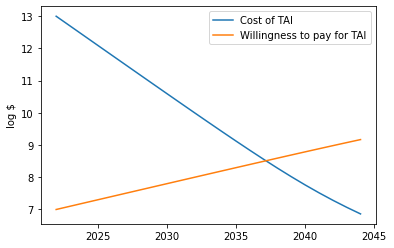

2044

In [36]:
def run_model(initial_gdp_, tai_flop_size_, nonscaling_delay_, algo_doubling_rate_,
              possible_algo_reduction_, initial_flops_per_dollar_, flops_halving_rate_,
              max_flops_per_dollar_, initial_pay_, gdp_growth_, max_gdp_frac_,
              willingness_ramp_, spend_doubling_time_, initial_chance_of_nonscaling_issue_,
              final_chance_of_nonscaling_issue_, nonscaling_issue_bottom_year_,
              willingness_spend_horizon_, print_diagnostic):
    queue_tai_year = 99999
    plt.ioff()
    if print_diagnostic:
        cost_of_tai_collector = []
        willingness_collector = []
    
    if print_diagnostic:
        print('It takes {} log FLOPs (~{}) for transformative capabilities.'.format(np.round(tai_flop_size_, 1),
                                                                                    sq.numerize(tai_flop_size_)))
        print('Every {} years algorithms get 2x better, with {} log reductions possible.'.format(np.round(algo_doubling_rate_, 1),
                                                                                                 np.round(possible_algo_reduction_, 1)))
        print(('FLOPs start at a cost of {} log FLOPs (~{}) per 2022$USD. Every {} years they get ' +
               '2x cheaper, to a maximum of {} log FLOPs (~{}) per 2022$USD.').format(np.round(math.log10(initial_flops_per_dollar_), 1),
                                                                               sq.numerize(math.log10(initial_flops_per_dollar_)),
                                                                               np.round(flops_halving_rate_, 1),
                                                                               np.round(math.log10(max_flops_per_dollar_), 1),
                                                                               sq.numerize(math.log10(max_flops_per_dollar_))))
        print(('We are willing to pay {} log 2022$USD (~{}) and this increases by {}x per year to a max of {}% of GDP. ' +
               'GDP grows at a rate of {}x per year.').format(np.round(math.log10(initial_pay_), 1),
                                                              sq.numerize(math.log10(initial_pay_)),
                                                              np.round(spend_doubling_time_, 1),
                                                              np.round(max_gdp_frac_, 4),
                                                              np.round(gdp_growth_, 3)))
        if willingness_ramp_ < 1:
            print('In this simulation, if we are {}% of the way to paying for TAI, we will ramp to paying for TAI.'.format(np.round(willingness_ramp_ * 100)))

        if willingness_spend_horizon_ > 1:
            print('We are willing to spend over {} years to make TAI'.format(willingness_spend_horizon_))
            
        print(('If a non-scaling delay happens, it will take an additional {} years to produce TAI due' +
               ' to issues unrelated to scaling FLOP').format(np.round(nonscaling_delay_, 1)))
        print('---')
    
    tai_created = False
    is_nonscaling_issue = None
    for y in years:
        if not tai_created:
            flops_needed_ = flops_needed(initial_flops=10 ** tai_flop_size_,
                                         doubling_rate=algo_doubling_rate_,
                                         possible_reduction=10 ** possible_algo_reduction_,
                                         year=(y - CURRENT_YEAR))
            
            flops_per_dollar_ = flops_per_dollar(initial_flops_per_dollar=initial_flops_per_dollar_,
                                                 max_flops_per_dollar=max_flops_per_dollar_,
                                                 halving_rate=flops_halving_rate_,
                                                 year=(y - CURRENT_YEAR))
            
            if flops_per_dollar_ > 10 ** 200 or flops_needed_ > 10 ** 200:
                flops_needed_ = int(flops_needed_)
                flops_per_dollar_ = int(flops_per_dollar_)
                cost_of_tai_ = flops_needed_ // flops_per_dollar_
            else:
                cost_of_tai_ = flops_needed_ / flops_per_dollar_
            
            willingness_ = willingness_to_pay(initial_gdp=initial_gdp_,
                                              gdp_growth=gdp_growth_,
                                              initial_pay=initial_pay_,
                                              spend_doubling_time=spend_doubling_time_,
                                              max_gdp_frac=max_gdp_frac_,
                                              year=(y - CURRENT_YEAR))
            
            if flops_per_dollar_ > 10 ** 200:
                willingness_ = int(willingness_)
            if willingness_ > 10 ** 200:
                flops_per_dollar_ = int(flops_per_dollar_)
            
            if print_diagnostic:
                cost_of_tai_collector.append(cost_of_tai_)
                willingness_collector.append(willingness_)
            
            total_compute_ = willingness_ * flops_per_dollar_
            
            if print_diagnostic:
                out_str = ('Year: {} - {} max log FLOP ({}) available - TAI takes {} log FLOP ({}) - ' +
                           'log $ {} to buy TAI ({}) vs. willingness to pay log $ {} ({}) - {} log FLOPS per $ ({})')
                print(out_str.format(y,
                                     np.round(math.log10(total_compute_), 1),
                                     sq.numerize(math.log10(total_compute_)),
                                     np.round(math.log10(flops_needed_), 1),
                                     sq.numerize(math.log10(flops_needed_)),
                                     np.round(math.log10(cost_of_tai_), 1),
                                     sq.numerize(math.log10(cost_of_tai_)),
                                     np.round(math.log10(willingness_), 1),
                                     sq.numerize(math.log10(willingness_)),
                                     np.round(math.log10(flops_per_dollar_), 1),
                                     sq.numerize(math.log10(flops_per_dollar_))))
            
            if cost_of_tai_ > 10 ** 200:
                spend_tai_years = int(cost_of_tai_) // int(willingness_)
            else:
                spend_tai_years = cost_of_tai_ / willingness_
                
            if not is_nonscaling_issue and queue_tai_year < 99999 and print_diagnostic:
                print('-$- {}/{}'.format(y, queue_tai_year))
            if (cost_of_tai_ * willingness_ramp_) <= willingness_ or y >= queue_tai_year:
                if is_nonscaling_issue is None:
                    p_nonscaling_delay_ = p_nonscaling_delay(initial_chance_of_nonscaling_issue_,
                                                             final_chance_of_nonscaling_issue_,
                                                             year=y,
                                                             max_year=nonscaling_issue_bottom_year_)
                    r_ = random.random()
                    is_nonscaling_issue = r_ < p_nonscaling_delay_
                    nonscaling_countdown = nonscaling_delay_
                    if print_diagnostic:
                        print('-- {} p_nonscaling_issue={} r_={}'.format('Nonscaling delay occured' if is_nonscaling_issue else 'Nonscaling issue did not occur',
                                                                         np.round(p_nonscaling_delay_, 4),
                                                                         np.round(r_, 4)))
                
                if not is_nonscaling_issue or nonscaling_countdown <= 0.1:
                    if print_diagnostic:
                        print('--- /!\ TAI CREATED in {}'.format(y))
                        plot_tai(plt, years, cost_of_tai_collector, willingness_collector).show()
                    return y
                else:
                    if print_diagnostic:
                        print('/!\ FLOPs for TAI sufficient but needs {} more years to solve non-scaling issues'.format(np.round(nonscaling_countdown, 1)))
                    nonscaling_countdown -= 1
            elif (not is_nonscaling_issue and willingness_spend_horizon_ > 1 and
                  spend_tai_years <= willingness_spend_horizon_ and y + math.ceil(spend_tai_years) < queue_tai_year):
                queue_tai_year = y + math.ceil(spend_tai_years)
                if print_diagnostic:
                    print('-$- We have enough spend to make TAI in {} years (in {}) if sustained.'.format(math.ceil(spend_tai_years),
                                                                                                          queue_tai_year))
                
    if not tai_created:
        if print_diagnostic:
            print('--- :/ TAI NOT CREATED BEFORE {}'.format(MAX_YEAR + 1))
            plot_tai(plt, years, cost_of_tai_collector, willingness_collector).show()
        return MAX_YEAR + 1

    
run_model(initial_gdp_ = 21*T,
          tai_flop_size_=31,
          nonscaling_delay_=6,
          algo_doubling_rate_=2,
          possible_algo_reduction_=3,
          initial_flops_per_dollar_=10 ** 18,
          flops_halving_rate_=2,
          max_flops_per_dollar_=10 ** 24,
          initial_pay_=10*M,
          gdp_growth_=1.025,
          max_gdp_frac_=1/(2*K),
          willingness_ramp_=1,
          spend_doubling_time_=3,
          initial_chance_of_nonscaling_issue_=0.9,
          final_chance_of_nonscaling_issue_=0.1,
          nonscaling_issue_bottom_year_=2050,
          willingness_spend_horizon_=10,
          print_diagnostic=True)
    

Running
## RUN 1/10000 ##
Anchor debug:
-- Assume human brain in inference takes 12.7 log FLOP
-- Add 0 log FLOP for efficiency
-- Assume a transformative model takes 0.8 log FLOP compared to human
-- Assume a horizon length of 9.3
-- Assume a scaling exponent of 1.366
-- Assume FLOPs per param per sec of 1.1
-- 35.3 = 12.7 + 0 + 0.8 + 9.3 + 12 - 1.366 * 11.2 + 1.366 * (12.7 + 0 - 1.1)
-- 35.3 after Bayes update
-
It takes 35.3 log FLOPs (~100 decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 1.2 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~one quintillion) per 2022$USD. Every 1.8 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 7.3 log 2022$USD (~10 million) and this increases by 4.1x per year to a max of 0.0008% of GDP. GDP grows at a rate of 1.016x per year.
If a non-scaling delay happens, it will take an additional 3.7 years to produce TAI due to issues unre

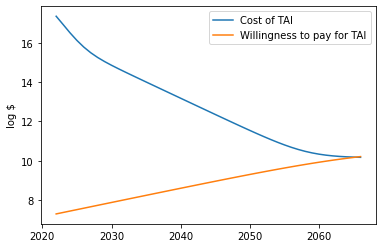

## RUN 2/10000 ##
Anchor debug:
-- Assume human brain in inference takes 13.9 log FLOP
-- Add 2.5 log FLOP for efficiency
-- Assume a transformative model takes -0.7 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.129
-- Assume FLOPs per param per sec of 1.4
-- 31.9 = 13.9 + 2.5 + -0.7 + 0 + 12 - 1.129 * 11.2 + 1.129 * (13.9 + 2.5 - 1.4)
-- 31.9 after Bayes update
-
It takes 31.9 log FLOPs (~10 nonillion) for transformative capabilities.
Every 1.1 years algorithms get 2x better, with 3.1 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~one quintillion) per 2022$USD. Every 3.6 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 7.3 log 2022$USD (~10 million) and this increases by 5.3x per year to a max of 0.0006% of GDP. GDP grows at a rate of 1.015x per year.
If a non-scaling delay happens, it will take an additional 4.5 years to produce TAI due to issues unrelated

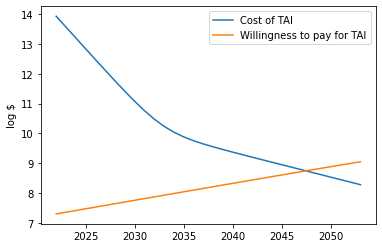

## RUN 3/10000 ##
Anchor debug:
-- Assume human brain in inference takes 14.4 log FLOP
-- Add 0 log FLOP for efficiency
-- Assume a transformative model takes 0.0 log FLOP compared to human
-- Assume a horizon length of 0.3
-- Assume a scaling exponent of 1.296
-- Assume FLOPs per param per sec of 1.5
-- 29.0 = 14.4 + 0 + 0.0 + 0.3 + 12 - 1.296 * 11.2 + 1.296 * (14.4 + 0 - 1.5)
-- 29.0 after Bayes update
-
It takes 29.0 log FLOPs (~10 octillion) for transformative capabilities.
Every 2.7 years algorithms get 2x better, with 0 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~one quintillion) per 2022$USD. Every 3.0 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 7.3 log 2022$USD (~10 million) and this increases by 1.2x per year to a max of 0.0009% of GDP. GDP grows at a rate of 1.012x per year.
If a non-scaling delay happens, it will take an additional 2.7 years to produce TAI due to issues unrelated to sc

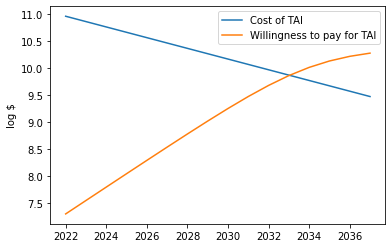

## RUN 4/10000 ##
Anchor debug:
-- Assume human brain in inference takes 12.8 log FLOP
-- Add 1.8 log FLOP for efficiency
-- Assume a transformative model takes -1.2 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.293
-- Assume FLOPs per param per sec of 2.1
-- 27.1 = 12.8 + 1.8 + -1.2 + 0 + 12 - 1.293 * 11.2 + 1.293 * (12.8 + 1.8 - 2.1)
-- 27.1 after Bayes update
-
It takes 27.1 log FLOPs (~one octillion) for transformative capabilities.
Every 1.2 years algorithms get 2x better, with 2.3 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~one quintillion) per 2022$USD. Every 3.9 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 7.3 log 2022$USD (~10 million) and this increases by 2.3x per year to a max of 0.0011% of GDP. GDP grows at a rate of 1.028x per year.
If a non-scaling delay happens, it will take an additional 2.1 years to produce TAI due to issues unrelate

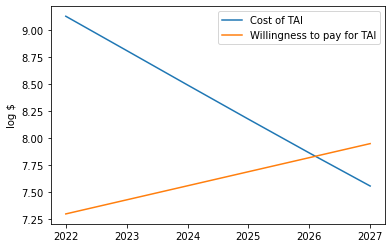

## RUN 5/10000 ##
Anchor debug:
-- Assume human brain in inference takes 17.6 log FLOP
-- Add 1.5 log FLOP for efficiency
-- Assume a transformative model takes -1.0 log FLOP compared to human
-- Assume a horizon length of 9.1
-- Assume a scaling exponent of 0.535
-- Assume FLOPs per param per sec of 1.2
-- 42.7 = 17.6 + 1.5 + -1.0 + 9.1 + 12 - 0.535 * 11.2 + 0.535 * (17.6 + 1.5 - 1.2)
-- 42.7 after Bayes update
-
It takes 42.7 log FLOPs (~one billion decillion) for transformative capabilities.
Every 1.6 years algorithms get 2x better, with 1.5 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~one quintillion) per 2022$USD. Every 3.2 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 7.3 log 2022$USD (~10 million) and this increases by 2.6x per year to a max of 0.001% of GDP. GDP grows at a rate of 1.031x per year.
If a non-scaling delay happens, it will take an additional 1.6 years to produce TAI due to issu

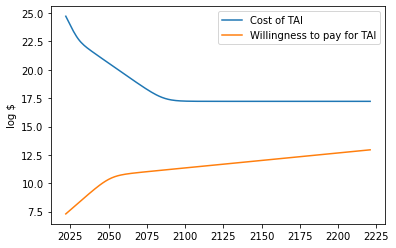

## RUN 6/10000 ##
Anchor debug:
-- Assume human brain in inference takes 13.0 log FLOP
-- Add 2.9 log FLOP for efficiency
-- Assume a transformative model takes -0.7 log FLOP compared to human
-- Assume a horizon length of 3.2
-- Assume a scaling exponent of 0.26
-- Assume FLOPs per param per sec of 1.2
-- 31.4 = 13.0 + 2.9 + -0.7 + 3.2 + 12 - 0.26 * 11.2 + 0.26 * (13.0 + 2.9 - 1.2)
-- 31.4 after Bayes update
-
It takes 31.4 log FLOPs (~10 nonillion) for transformative capabilities.
Every 1.8 years algorithms get 2x better, with 4.3 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~one quintillion) per 2022$USD. Every 3.8 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 7.3 log 2022$USD (~10 million) and this increases by 3.8x per year to a max of 0.0006% of GDP. GDP grows at a rate of 1.028x per year.
If a non-scaling delay happens, it will take an additional 6.4 years to produce TAI due to issues unrelate

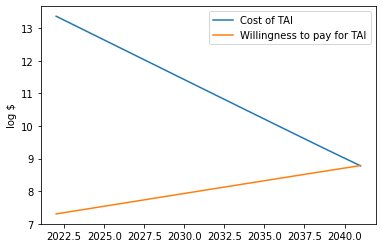

## RUN 7/10000 ##
Anchor debug:
-- Assume human brain in inference takes 15.8 log FLOP
-- Add 1.4 log FLOP for efficiency
-- Assume a transformative model takes -0.3 log FLOP compared to human
-- Assume a horizon length of 7.1
-- Assume a scaling exponent of 0.738
-- Assume FLOPs per param per sec of 1.8
-- 39.0 = 15.8 + 1.4 + -0.3 + 7.1 + 12 - 0.738 * 11.2 + 0.738 * (15.8 + 1.4 - 1.8)
-- 39.0 after Bayes update
-
It takes 39.0 log FLOPs (~one million decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 1.4 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~one quintillion) per 2022$USD. Every 2.9 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 7.9 log 2022$USD (~10 million) and this increases by 3.1x per year to a max of 0.0002% of GDP. GDP grows at a rate of 1.017x per year.
If a non-scaling delay happens, it will take an additional 4.2 years to produce TAI due to iss

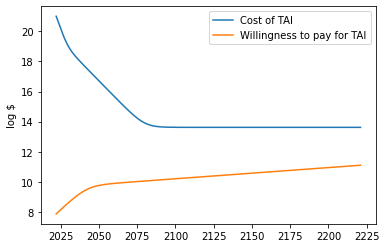

## RUN 8/10000 ##
Anchor debug:
-- Assume human brain in inference takes 11.6 log FLOP
-- Add 1.9 log FLOP for efficiency
-- Assume a transformative model takes -1.7 log FLOP compared to human
-- Assume a horizon length of 7.7
-- Assume a scaling exponent of 0.788
-- Assume FLOPs per param per sec of 1.5
-- 32.3 = 11.6 + 1.9 + -1.7 + 7.7 + 12 - 0.788 * 11.2 + 0.788 * (11.6 + 1.9 - 1.5)
-- 32.3 after Bayes update
-
It takes 32.3 log FLOPs (~100 nonillion) for transformative capabilities.
Every 1.8 years algorithms get 2x better, with 2.9 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~one quintillion) per 2022$USD. Every 3.3 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 7.3 log 2022$USD (~10 million) and this increases by 5.5x per year to a max of 0.0005% of GDP. GDP grows at a rate of 1.034x per year.
If a non-scaling delay happens, it will take an additional 9.0 years to produce TAI due to issues unre

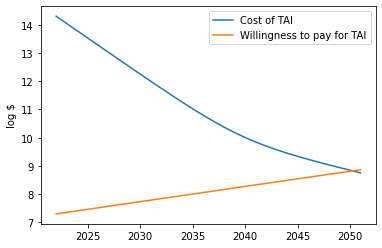

## RUN 9/10000 ##
Anchor debug:
-- Assume human brain in inference takes 11.7 log FLOP
-- Add 2.1 log FLOP for efficiency
-- Assume a transformative model takes 0.9 log FLOP compared to human
-- Assume a horizon length of 2.8
-- Assume a scaling exponent of 1.084
-- Assume FLOPs per param per sec of 1.3
-- 31.0 = 11.7 + 2.1 + 0.9 + 2.8 + 12 - 1.084 * 11.2 + 1.084 * (11.7 + 2.1 - 1.3)
-- 31.0 after Bayes update
-
It takes 31.0 log FLOPs (~one nonillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 2.1 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~one quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 7.3 log 2022$USD (~10 million) and this increases by 2.5x per year to a max of 0.0086% of GDP. GDP grows at a rate of 1.024x per year.
If a non-scaling delay happens, it will take an additional 6.3 years to produce TAI due to issues unrela

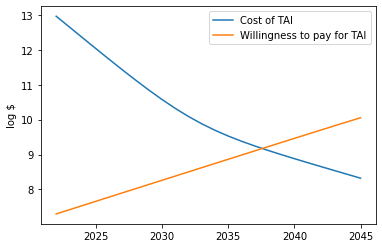

## RUN 10/10000 ##
Anchor debug:
-- Assume human brain in inference takes 17.9 log FLOP
-- Add 1.0 log FLOP for efficiency
-- Assume a transformative model takes -0.5 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.448
-- Assume FLOPs per param per sec of 1.9
-- 38.5 = 17.9 + 1.0 + -0.5 + 0 + 12 - 1.448 * 11.2 + 1.448 * (17.9 + 1.0 - 1.9)
-- 38.5 after Bayes update
-
It takes 38.5 log FLOPs (~100 thousand decillion) for transformative capabilities.
Every 1.6 years algorithms get 2x better, with 0.9 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~one quintillion) per 2022$USD. Every 3.2 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 7.3 log 2022$USD (~10 million) and this increases by 3.1x per year to a max of 0.004% of GDP. GDP grows at a rate of 1.031x per year.
If a non-scaling delay happens, it will take an additional 2.5 years to produce TAI due to issues

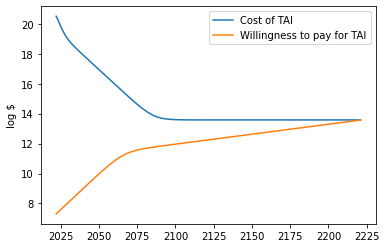

## RUN 11/10000 ##
Anchor debug:
-- Assume human brain in inference takes 14.0 log FLOP
-- Add 0 log FLOP for efficiency
-- Assume a transformative model takes 0.3 log FLOP compared to human
-- Assume a horizon length of 3.5
-- Assume a scaling exponent of 1.281
-- Assume FLOPs per param per sec of 1.6
-- 31.2 = 14.0 + 0 + 0.3 + 3.5 + 12 - 1.281 * 11.2 + 1.281 * (14.0 + 0 - 1.6)
-- 31.2 after Bayes update
-
It takes 31.2 log FLOPs (~10 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 0 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~one quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 7.3 log 2022$USD (~10 million) and this increases by 4.8x per year to a max of 0.0011% of GDP. GDP grows at a rate of 1.034x per year.
If a non-scaling delay happens, it will take an additional 4.6 years to produce TAI due to issues unrelated to s

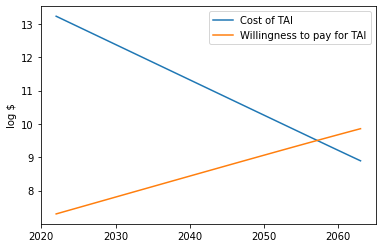

## RUN 12/10000 ##
Anchor debug:
-- Assume human brain in inference takes 13.1 log FLOP
-- Add 5.0 log FLOP for efficiency
-- Assume a transformative model takes -1.3 log FLOP compared to human
-- Assume a horizon length of 4.9
-- Assume a scaling exponent of 1.172
-- Assume FLOPs per param per sec of 1.7
-- 39.7 = 13.1 + 5.0 + -1.3 + 4.9 + 12 - 1.172 * 11.2 + 1.172 * (13.1 + 5.0 - 1.7)
-- 39.7 after Bayes update
-
It takes 39.7 log FLOPs (~one million decillion) for transformative capabilities.
Every 1.3 years algorithms get 2x better, with 5.0 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~one quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 7.3 log 2022$USD (~10 million) and this increases by 1.8x per year to a max of 0.0005% of GDP. GDP grows at a rate of 1.008x per year.
If a non-scaling delay happens, it will take an additional 8.3 years to produce TAI due to is

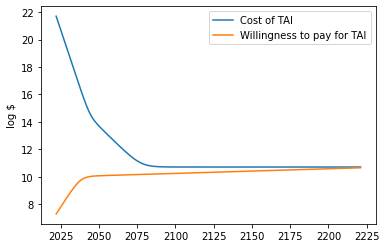

## RUN 13/10000 ##
Anchor debug:
-- Assume human brain in inference takes 21.0 log FLOP
-- Add 1.2 log FLOP for efficiency
-- Assume a transformative model takes -0.9 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 0.772
-- Assume FLOPs per param per sec of 1.4
-- 40.7 = 21.0 + 1.2 + -0.9 + 0 + 12 - 0.772 * 11.2 + 0.772 * (21.0 + 1.2 - 1.4)
-- 40.7 after Bayes update
-
It takes 40.7 log FLOPs (~10 million decillion) for transformative capabilities.
Every 1.1 years algorithms get 2x better, with 2.0 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~one quintillion) per 2022$USD. Every 2.1 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 7.3 log 2022$USD (~10 million) and this increases by 1.6x per year to a max of 0.0008% of GDP. GDP grows at a rate of 1.031x per year.
If a non-scaling delay happens, it will take an additional 2.8 years to produce TAI due to issues 

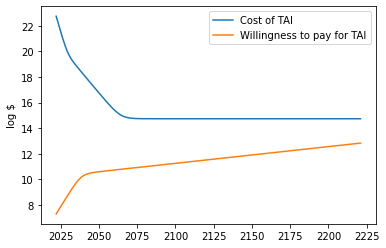

## RUN 14/10000 ##
Anchor debug:
-- Assume human brain in inference takes 10.5 log FLOP
-- Add 1.5 log FLOP for efficiency
-- Assume a transformative model takes -0.6 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.504
-- Assume FLOPs per param per sec of 1.4
-- 22.5 = 10.5 + 1.5 + -0.6 + 0 + 12 - 1.504 * 11.2 + 1.504 * (10.5 + 1.5 - 1.4)
-- 22.5 after Bayes update
-
It takes 22.5 log FLOPs (~10 sextillion) for transformative capabilities.
Every 3.3 years algorithms get 2x better, with 2.2 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~one quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 7.3 log 2022$USD (~10 million) and this increases by 1.5x per year to a max of 0.0007% of GDP. GDP grows at a rate of 1.014x per year.
If a non-scaling delay happens, it will take an additional 2.6 years to produce TAI due to issues unrelat

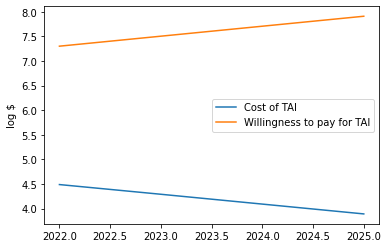

## RUN 15/10000 ##
Anchor debug:
-- Assume human brain in inference takes 16.1 log FLOP
-- Add 1.2 log FLOP for efficiency
-- Assume a transformative model takes -0.3 log FLOP compared to human
-- Assume a horizon length of 9.9
-- Assume a scaling exponent of 1.307
-- Assume FLOPs per param per sec of 0.8
-- 45.9 = 16.1 + 1.2 + -0.3 + 9.9 + 12 - 1.307 * 11.2 + 1.307 * (16.1 + 1.2 - 0.8)
-- 45.9 after Bayes update
-
It takes 45.9 log FLOPs (~one trillion decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 1.8 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~one quintillion) per 2022$USD. Every 3.2 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 7.3 log 2022$USD (~10 million) and this increases by 5.6x per year to a max of 0.0026% of GDP. GDP grows at a rate of 1.03x per year.
If a non-scaling delay happens, it will take an additional 6.9 years to produce TAI due to is

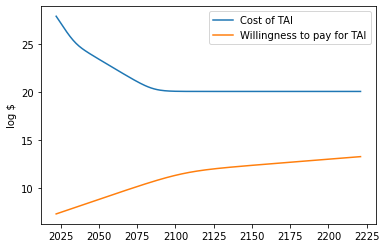

## RUN 16/10000 ##
Anchor debug:
-- Assume human brain in inference takes 14.3 log FLOP
-- Add 1.1 log FLOP for efficiency
-- Assume a transformative model takes 0.0 log FLOP compared to human
-- Assume a horizon length of 4.3
-- Assume a scaling exponent of 0.72
-- Assume FLOPs per param per sec of 1.6
-- 33.6 = 14.3 + 1.1 + 0.0 + 4.3 + 12 - 0.72 * 11.2 + 0.72 * (14.3 + 1.1 - 1.6)
-- 33.6 after Bayes update
-
It takes 33.6 log FLOPs (~one decillion) for transformative capabilities.
Every 1.3 years algorithms get 2x better, with 1.8 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~one quintillion) per 2022$USD. Every 2.9 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 7.3 log 2022$USD (~10 million) and this increases by 3.1x per year to a max of 0.0021% of GDP. GDP grows at a rate of 1.026x per year.
If a non-scaling delay happens, it will take an additional 7.6 years to produce TAI due to issues unrelate

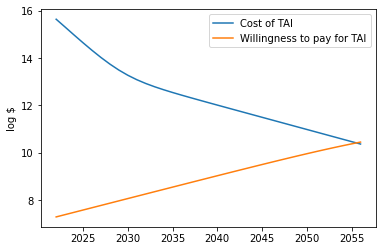

## RUN 17/10000 ##
Anchor debug:
-- Assume human brain in inference takes 13.3 log FLOP
-- Add 1.1 log FLOP for efficiency
-- Assume a transformative model takes 0.2 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 0.937
-- Assume FLOPs per param per sec of 1.7
-- 28.0 = 13.3 + 1.1 + 0.2 + 0 + 12 - 0.937 * 11.2 + 0.937 * (13.3 + 1.1 - 1.7)
-- 28.0 after Bayes update
-
It takes 28.0 log FLOPs (~10 octillion) for transformative capabilities.
Every 2.2 years algorithms get 2x better, with 1.1 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~one quintillion) per 2022$USD. Every 2.9 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 7.3 log 2022$USD (~10 million) and this increases by 2.9x per year to a max of 0.0006% of GDP. GDP grows at a rate of 1.017x per year.
If a non-scaling delay happens, it will take an additional 3.6 years to produce TAI due to issues unrelated 

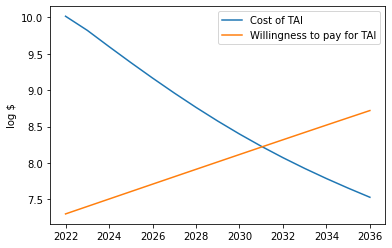

## RUN 18/10000 ##
Anchor debug:
-- Assume human brain in inference takes 17.3 log FLOP
-- Add 3.5 log FLOP for efficiency
-- Assume a transformative model takes -0.6 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.022
-- Assume FLOPs per param per sec of 1.2
-- 40.7 = 17.3 + 3.5 + -0.6 + 0 + 12 - 1.022 * 11.2 + 1.022 * (17.3 + 3.5 - 1.2)
-- 40.7 after Bayes update
-
It takes 40.7 log FLOPs (~10 million decillion) for transformative capabilities.
Every 1.1 years algorithms get 2x better, with 4.9 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~one quintillion) per 2022$USD. Every 5.8 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 7.3 log 2022$USD (~10 million) and this increases by 1.7x per year to a max of 0.0007% of GDP. GDP grows at a rate of 1.029x per year.
If a non-scaling delay happens, it will take an additional 5.2 years to produce TAI due to issues 

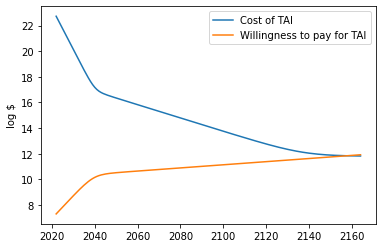

## RUN 19/10000 ##
Anchor debug:
-- Assume human brain in inference takes 9.0 log FLOP
-- Add 1.3 log FLOP for efficiency
-- Assume a transformative model takes -0.5 log FLOP compared to human
-- Assume a horizon length of 3.3
-- Assume a scaling exponent of 0.302
-- Assume FLOPs per param per sec of 1.6
-- 24.5 = 9.0 + 1.3 + -0.5 + 3.3 + 12 - 0.302 * 11.2 + 0.302 * (9.0 + 1.3 - 1.6)
-- 26.0 after Bayes update
-
It takes 26.0 log FLOPs (~10 septillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2.0 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~one quintillion) per 2022$USD. Every 3.8 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 7.3 log 2022$USD (~10 million) and this increases by 3.7x per year to a max of 0.0008% of GDP. GDP grows at a rate of 1.033x per year.
If a non-scaling delay happens, it will take an additional 4.9 years to produce TAI due to issues unrela

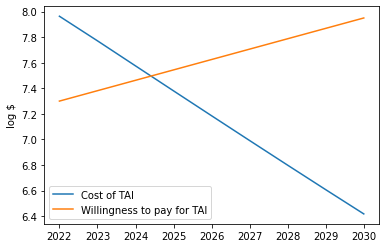

## RUN 20/10000 ##
Anchor debug:
-- Assume human brain in inference takes 12.8 log FLOP
-- Add 2.7 log FLOP for efficiency
-- Assume a transformative model takes 0.8 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.065
-- Assume FLOPs per param per sec of 1.5
-- 31.3 = 12.8 + 2.7 + 0.8 + 0 + 12 - 1.065 * 11.2 + 1.065 * (12.8 + 2.7 - 1.5)
-- 31.3 after Bayes update
-
It takes 31.3 log FLOPs (~10 nonillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3.5 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~one quintillion) per 2022$USD. Every 2.0 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 7.3 log 2022$USD (~10 million) and this increases by 1.6x per year to a max of 0.0006% of GDP. GDP grows at a rate of 1.023x per year.
If a non-scaling delay happens, it will take an additional 4.4 years to produce TAI due to issues unrelated 

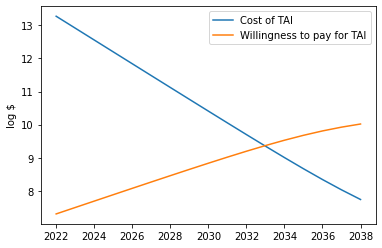

## RUN 21/10000 ##
Anchor debug:
-- Assume human brain in inference takes 14.7 log FLOP
-- Add 2.1 log FLOP for efficiency
-- Assume a transformative model takes -2.3 log FLOP compared to human
-- Assume a horizon length of 3.5
-- Assume a scaling exponent of 1.35
-- Assume FLOPs per param per sec of 2.3
-- 34.5 = 14.7 + 2.1 + -2.3 + 3.5 + 12 - 1.35 * 11.2 + 1.35 * (14.7 + 2.1 - 2.3)
-- 34.5 after Bayes update
-
It takes 34.5 log FLOPs (~10 decillion) for transformative capabilities.
Every 1.3 years algorithms get 2x better, with 2.1 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~one quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 7.6 log 2022$USD (~10 million) and this increases by 3.0x per year to a max of 0.0007% of GDP. GDP grows at a rate of 1.024x per year.
If a non-scaling delay happens, it will take an additional 3.3 years to produce TAI due to issues unrelat

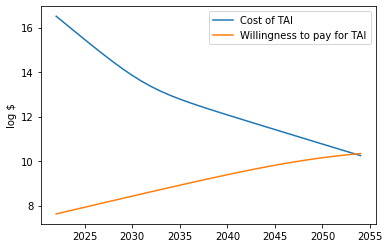

## RUN 22/10000 ##
Anchor debug:
-- Assume human brain in inference takes 16.7 log FLOP
-- Add 1.5 log FLOP for efficiency
-- Assume a transformative model takes 0.7 log FLOP compared to human
-- Assume a horizon length of 5.4
-- Assume a scaling exponent of 1.002
-- Assume FLOPs per param per sec of 0.9
-- 42.4 = 16.7 + 1.5 + 0.7 + 5.4 + 12 - 1.002 * 11.2 + 1.002 * (16.7 + 1.5 - 0.9)
-- 42.4 after Bayes update
-
It takes 42.4 log FLOPs (~one billion decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 2.5 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~one quintillion) per 2022$USD. Every 3.2 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 7.3 log 2022$USD (~10 million) and this increases by 2.5x per year to a max of 0.0009% of GDP. GDP grows at a rate of 1.028x per year.
If a non-scaling delay happens, it will take an additional 5.8 years to produce TAI due to issu

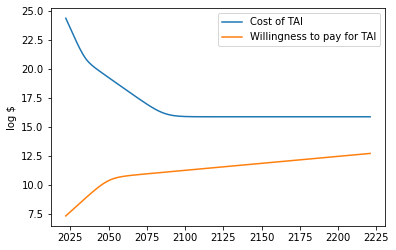

## RUN 23/10000 ##
Anchor debug:
-- Assume human brain in inference takes 14.1 log FLOP
-- Add 1.6 log FLOP for efficiency
-- Assume a transformative model takes -0.6 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 0.628
-- Assume FLOPs per param per sec of 1.8
-- 28.7 = 14.1 + 1.6 + -0.6 + 0 + 12 - 0.628 * 11.2 + 0.628 * (14.1 + 1.6 - 1.8)
-- 28.7 after Bayes update
-
It takes 28.7 log FLOPs (~10 octillion) for transformative capabilities.
Every 1.9 years algorithms get 2x better, with 1.6 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~one quintillion) per 2022$USD. Every 5.5 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 7.3 log 2022$USD (~10 million) and this increases by 1.4x per year to a max of 0.0007% of GDP. GDP grows at a rate of 1.019x per year.
If a non-scaling delay happens, it will take an additional 5.4 years to produce TAI due to issues unrelate

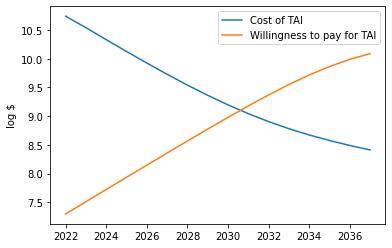

## RUN 24/10000 ##
Anchor debug:
-- Assume human brain in inference takes 10.8 log FLOP
-- Add 1.9 log FLOP for efficiency
-- Assume a transformative model takes -1.1 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.347
-- Assume FLOPs per param per sec of 1.9
-- 23.1 = 10.8 + 1.9 + -1.1 + 0 + 12 - 1.347 * 11.2 + 1.347 * (10.8 + 1.9 - 1.9)
-- 25.7 after Bayes update
-
It takes 25.7 log FLOPs (~10 septillion) for transformative capabilities.
Every 1.9 years algorithms get 2x better, with 2.9 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~one quintillion) per 2022$USD. Every 2.1 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 7.3 log 2022$USD (~10 million) and this increases by 1.3x per year to a max of 0.0008% of GDP. GDP grows at a rate of 1.025x per year.
If a non-scaling delay happens, it will take an additional 9.8 years to produce TAI due to issues unrelat

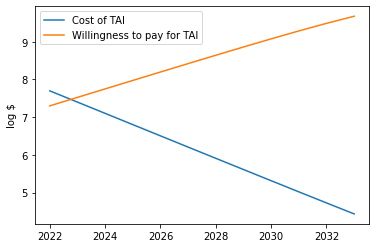

## RUN 25/10000 ##
Anchor debug:
-- Assume human brain in inference takes 17.8 log FLOP
-- Add 3.4 log FLOP for efficiency
-- Assume a transformative model takes -1.2 log FLOP compared to human
-- Assume a horizon length of 5.7
-- Assume a scaling exponent of 0.564
-- Assume FLOPs per param per sec of 2.1
-- 41.9 = 17.8 + 3.4 + -1.2 + 5.7 + 12 - 0.564 * 11.2 + 0.564 * (17.8 + 3.4 - 2.1)
-- 41.9 after Bayes update
-
It takes 41.9 log FLOPs (~100 million decillion) for transformative capabilities.
Every 1.8 years algorithms get 2x better, with 3.4 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~one quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 7.3 log 2022$USD (~10 million) and this increases by 2.1x per year to a max of 0.0005% of GDP. GDP grows at a rate of 1.015x per year.
If a non-scaling delay happens, it will take an additional 7.3 years to produce TAI due to is

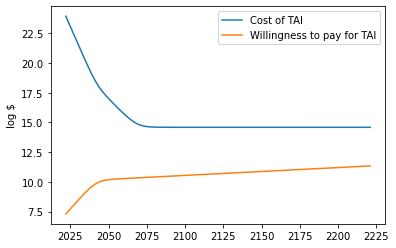

## RUN 26/10000 ##
Anchor debug:
-- Assume human brain in inference takes 12.1 log FLOP
-- Add 0 log FLOP for efficiency
-- Assume a transformative model takes 0.3 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 0.897
-- Assume FLOPs per param per sec of 1.7
-- 23.7 = 12.1 + 0 + 0.3 + 0 + 12 - 0.897 * 11.2 + 0.897 * (12.1 + 0 - 1.7)
-- 26.1 after Bayes update
-
It takes 26.1 log FLOPs (~100 septillion) for transformative capabilities.
Every 2.3 years algorithms get 2x better, with 1.5 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~one quintillion) per 2022$USD. Every 3.7 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 7.3 log 2022$USD (~10 million) and this increases by 4.3x per year to a max of 0.001% of GDP. GDP grows at a rate of 1.028x per year.
If a non-scaling delay happens, it will take an additional 7.8 years to produce TAI due to issues unrelated to sc

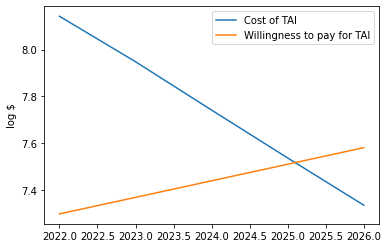

## RUN 27/10000 ##
Anchor debug:
-- Assume human brain in inference takes 15.6 log FLOP
-- Add 2.8 log FLOP for efficiency
-- Assume a transformative model takes 1.4 log FLOP compared to human
-- Assume a horizon length of 5.9
-- Assume a scaling exponent of 1.074
-- Assume FLOPs per param per sec of 1.3
-- 44.0 = 15.6 + 2.8 + 1.4 + 5.9 + 12 - 1.074 * 11.2 + 1.074 * (15.6 + 2.8 - 1.3)
-- 44.0 after Bayes update
-
It takes 44.0 log FLOPs (~100 billion decillion) for transformative capabilities.
Every 1.8 years algorithms get 2x better, with 3.8 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~one quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 7.3 log 2022$USD (~10 million) and this increases by 1.9x per year to a max of 0.0008% of GDP. GDP grows at a rate of 1.036x per year.
If a non-scaling delay happens, it will take an additional 4.4 years to produce TAI due to issu

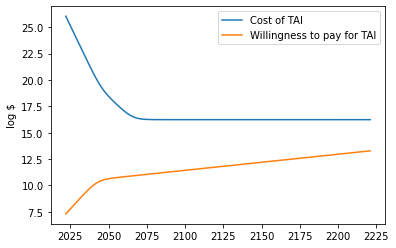

## RUN 28/10000 ##
Anchor debug:
-- Assume human brain in inference takes 14.5 log FLOP
-- Add 0 log FLOP for efficiency
-- Assume a transformative model takes -1.3 log FLOP compared to human
-- Assume a horizon length of 1.5
-- Assume a scaling exponent of 1.051
-- Assume FLOPs per param per sec of 1.9
-- 28.3 = 14.5 + 0 + -1.3 + 1.5 + 12 - 1.051 * 11.2 + 1.051 * (14.5 + 0 - 1.9)
-- 28.3 after Bayes update
-
It takes 28.3 log FLOPs (~10 octillion) for transformative capabilities.
Every 1.3 years algorithms get 2x better, with 0.5 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~one quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 7.3 log 2022$USD (~10 million) and this increases by 4.1x per year to a max of 0.0006% of GDP. GDP grows at a rate of 1.037x per year.
If a non-scaling delay happens, it will take an additional 2.5 years to produce TAI due to issues unrelated 

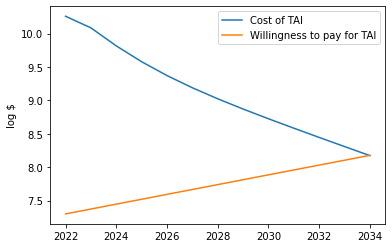

## RUN 29/10000 ##
Anchor debug:
-- Assume human brain in inference takes 21.7 log FLOP
-- Add 1.5 log FLOP for efficiency
-- Assume a transformative model takes -1.8 log FLOP compared to human
-- Assume a horizon length of 4.6
-- Assume a scaling exponent of 0.592
-- Assume FLOPs per param per sec of 1.6
-- 44.2 = 21.7 + 1.5 + -1.8 + 4.6 + 12 - 0.592 * 11.2 + 0.592 * (21.7 + 1.5 - 1.6)
-- 44.2 after Bayes update
-
It takes 44.2 log FLOPs (~100 billion decillion) for transformative capabilities.
Every 1.3 years algorithms get 2x better, with 3.1 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~one quintillion) per 2022$USD. Every 3.7 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 7.3 log 2022$USD (~10 million) and this increases by 2.0x per year to a max of 0.0067% of GDP. GDP grows at a rate of 1.027x per year.
If a non-scaling delay happens, it will take an additional 1.1 years to produce TAI due to is

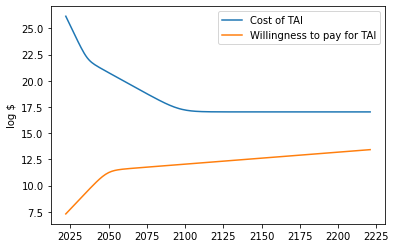

## RUN 30/10000 ##
Anchor debug:
-- Assume human brain in inference takes 16.4 log FLOP
-- Add 2.0 log FLOP for efficiency
-- Assume a transformative model takes 0.3 log FLOP compared to human
-- Assume a horizon length of 1.5
-- Assume a scaling exponent of 0.659
-- Assume FLOPs per param per sec of 1.5
-- 36.0 = 16.4 + 2.0 + 0.3 + 1.5 + 12 - 0.659 * 11.2 + 0.659 * (16.4 + 2.0 - 1.5)
-- 36.0 after Bayes update
-
It takes 36.0 log FLOPs (~100 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 2.0 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~one quintillion) per 2022$USD. Every 3.3 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 7.3 log 2022$USD (~10 million) and this increases by 4.8x per year to a max of 0.0019% of GDP. GDP grows at a rate of 1.034x per year.
If a non-scaling delay happens, it will take an additional 31.5 years to produce TAI due to issues unre

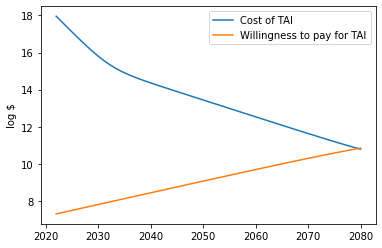

## RUN 201/10000 ##
## RUN 401/10000 ##
## RUN 601/10000 ##
## RUN 801/10000 ##
## RUN 1001/10000 ##
## RUN 1201/10000 ##
## RUN 1401/10000 ##
## RUN 1601/10000 ##
## RUN 1801/10000 ##
## RUN 2001/10000 ##
## RUN 2201/10000 ##
## RUN 2401/10000 ##
## RUN 2601/10000 ##
## RUN 2801/10000 ##
## RUN 3001/10000 ##
## RUN 3201/10000 ##
## RUN 3401/10000 ##
## RUN 3601/10000 ##
## RUN 3801/10000 ##
## RUN 4001/10000 ##
## RUN 4201/10000 ##
## RUN 4401/10000 ##
## RUN 4601/10000 ##
## RUN 4801/10000 ##
## RUN 5001/10000 ##
## RUN 5201/10000 ##
## RUN 5401/10000 ##
## RUN 5601/10000 ##
## RUN 5801/10000 ##
## RUN 6001/10000 ##
## RUN 6201/10000 ##
## RUN 6401/10000 ##
## RUN 6601/10000 ##
## RUN 6801/10000 ##
## RUN 7001/10000 ##
## RUN 7201/10000 ##
## RUN 7401/10000 ##
## RUN 7601/10000 ##
## RUN 7801/10000 ##
## RUN 8001/10000 ##
## RUN 8201/10000 ##
## RUN 8401/10000 ##
## RUN 8601/10000 ##
## RUN 8801/10000 ##
## RUN 9001/10000 ##
## RUN 9201/10000 ##
## RUN 9401/10000 ##
## RUN 9601/10000

In [37]:
print('Running')

def loop_model(r):
    print_diagnostic = r < 30
    if print_diagnostic or r % 200 == 0 or r >= RUNS - 1:
        print('## RUN {}/{} ##'.format(r + 1, RUNS))
        
    if variables.get('use_efficiency_based_algo_reduction'):
        efficiency = sq.sample(variables['efficiency'])
        tai_flop_size_ = sq.sample(lambda: variables['tai_flop_size'](efficiency=sq.const(efficiency),
                                                                      debug=print_diagnostic))
    else:
        tai_flop_size_ = sq.sample(variables['tai_flop_size'])

    if tai_flop_size_ > 300:
        tai_flop_size_ = int(tai_flop_size_) # Handle overflow errors
    
    algo_doubling_rate_ = algo_halving_fn(sq.sample(variables['algo_doubling_rate_min']),
                                          sq.sample(variables['algo_doubling_rate_max']),
                                          tai_flop_size_)
    
    if variables.get('use_efficiency_based_algo_reduction'):
        possible_algo_reduction_ = possible_algo_reduction_fn(efficiency, efficiency, tai_flop_size_)
        if variables.get('efficiency_based_additional_reduction'):
            possible_algo_reduction_ += sq.sample(variables.get('efficiency_based_additional_reduction'))
    else:
        possible_algo_reduction_ = possible_algo_reduction_fn(sq.sample(variables['min_reduction']),
                                                              sq.sample(variables['max_reduction']),
                                                              tai_flop_size_)
    
    initial_flops_per_dollar_ = 10 ** sq.sample(variables['initial_flops_per_dollar'])
    flops_halving_rate_ = sq.sample(variables['flops_halving_rate'])
    max_flops_per_dollar_ = 10 ** sq.sample(variables['max_flops_per_dollar'])
    initial_pay_ = 10 ** sq.sample(variables['initial_pay'])
    gdp_growth_ = sq.sample(variables['gdp_growth'])
    max_gdp_frac_ = sq.sample(variables['max_gdp_frac'])
    
    willingness_ramp_happens = sq.event_occurs(variables.get('p_willingness_ramp', 0))
    if willingness_ramp_happens:
        willingness_ramp_ = sq.sample(variables.get('willingness_ramp', 1))
    else:
        willingness_ramp_ = 1
    
    initial_gdp_ = variables['initial_gdp']
    spend_doubling_time_ = sq.sample(variables['spend_doubling_time'])
    nonscaling_delay_ = sq.sample(variables.get('nonscaling_delay', sq.const(0)))
    initial_chance_of_nonscaling_issue_ = variables.get('initial_chance_of_nonscaling_issue', 0)
    final_chance_of_nonscaling_issue_ = variables.get('final_chance_of_nonscaling_issue', 0)
    nonscaling_issue_bottom_year_ = variables.get('nonscaling_issue_bottom_year', 0)
    willingness_spend_horizon_ = int(sq.sample(variables.get('willingness_spend_horizon', sq.const(1))))
    
    return run_model(initial_gdp_=initial_gdp_,
                     tai_flop_size_=tai_flop_size_,
                     nonscaling_delay_=nonscaling_delay_,
                     algo_doubling_rate_=algo_doubling_rate_,
                     possible_algo_reduction_=possible_algo_reduction_,
                     initial_flops_per_dollar_=initial_flops_per_dollar_,
                     flops_halving_rate_=flops_halving_rate_,
                     max_flops_per_dollar_=max_flops_per_dollar_,
                     initial_pay_=initial_pay_,
                     gdp_growth_=gdp_growth_,
                     max_gdp_frac_=max_gdp_frac_,
                     willingness_ramp_=willingness_ramp_,
                     spend_doubling_time_=spend_doubling_time_,
                     initial_chance_of_nonscaling_issue_=initial_chance_of_nonscaling_issue_,
                     final_chance_of_nonscaling_issue_=final_chance_of_nonscaling_issue_,
                     nonscaling_issue_bottom_year_=nonscaling_issue_bottom_year_,
                     willingness_spend_horizon_=willingness_spend_horizon_,
                     print_diagnostic=print_diagnostic)

tai_years = [loop_model(r) for r in range(RUNS)]


In [38]:
out = sq.get_percentiles(tai_years)
[str(o[0]) + '%: ' + (str(int(o[1])) if o[1] < MAX_YEAR else '>' + str(MAX_YEAR)) for o in out.items()]

# NOTE: Ajeya's numbers should output something very close to:
# '5%': 2027,
# '10%: 2031',
# '20%: 2037',
# '30%: 2042',
# '40%: 2047',
# '50%: 2053',
# '60%: 2061',
# '70%: 2073',
# '80%: >2100',
# '90%: >2100',
# '95%: >2100'

# My latest numbers (2022 Aug 27 8:43PM CT):
# '1%: 2024',
# '5%: 2027',
# '10%: 2029',
# '20%: 2033',
# '30%: 2038',
# '40%: 2045',
# '50%: 2054',
# '60%: 2064',
# '70%: 2079',
# '80%: 2116',
# '90%: >2222',
# '95%: >2222',
# '99%: >2222']


['1%: 2025',
 '5%: 2029',
 '10%: 2032',
 '20%: 2038',
 '30%: 2044',
 '40%: 2053',
 '50%: 2065',
 '60%: 2083',
 '70%: 2174',
 '80%: >2222',
 '90%: >2222',
 '95%: >2222',
 '99%: >2222']

In [39]:
[str(o[0]) + '%: ' + (str(int(o[1]) - CURRENT_YEAR) if o[1] < MAX_YEAR else '>' + str(MAX_YEAR - CURRENT_YEAR)) + ' years from now' for o in out.items()]


['1%: 3 years from now',
 '5%: 7 years from now',
 '10%: 10 years from now',
 '20%: 16 years from now',
 '30%: 22 years from now',
 '40%: 31 years from now',
 '50%: 43 years from now',
 '60%: 61 years from now',
 '70%: 152 years from now',
 '80%: >200 years from now',
 '90%: >200 years from now',
 '95%: >200 years from now',
 '99%: >200 years from now']

In [40]:
def print_chance_tai_by_year(data, year_target):
    return '{}% chance of TAI by EOY {}'.format(int(np.round(sum([1 if y <= year_target else 0 for y in data]) / len(data) * 100, 0)),
                                                year_target)
    
print('## Within <1 years')
print_chance_tai_by_year(tai_years, 2022)


## Within <1 years


'0% chance of TAI by EOY 2022'

In [41]:
print('## Within <1 years')
print_chance_tai_by_year(tai_years, 2023)

## Within <1 years


'1% chance of TAI by EOY 2023'

In [42]:
print_chance_tai_by_year(tai_years, 2024)

'1% chance of TAI by EOY 2024'

In [43]:
print_chance_tai_by_year(tai_years, 2025)

'2% chance of TAI by EOY 2025'

In [44]:
print('## Within 5 years')
print_chance_tai_by_year(tai_years, 2027)

## Within 5 years


'3% chance of TAI by EOY 2027'

In [45]:
print_chance_tai_by_year(tai_years, 2029)

'6% chance of TAI by EOY 2029'

In [46]:
print_chance_tai_by_year(tai_years, 2030)

'7% chance of TAI by EOY 2030'

In [47]:
print('## Within 10 years')
print_chance_tai_by_year(tai_years, 2032)

## Within 10 years


'10% chance of TAI by EOY 2032'

In [48]:
# Holden benchmarks from https://www.cold-takes.com/biological-anchors-is-about-bounding-not-pinpointing-ai-timelines/#bio-anchors-as-a-way-of-bounding-ai-timelines
print('## Within 14 years (Holden benchmark - 10%-50%, Holden: 10%)')
print_chance_tai_by_year(tai_years, 2036)


## Within 14 years (Holden benchmark - 10%-50%, Holden: 10%)


'17% chance of TAI by EOY 2036'

In [49]:
print('## Within 15 years')
print_chance_tai_by_year(tai_years, 2037)

## Within 15 years


'19% chance of TAI by EOY 2037'

In [50]:
print_chance_tai_by_year(tai_years, 2040)

'24% chance of TAI by EOY 2040'

In [51]:
print('## Within 20 years')
print_chance_tai_by_year(tai_years, 2042)

## Within 20 years


'27% chance of TAI by EOY 2042'

In [52]:
print('## Within 25 years')
print_chance_tai_by_year(tai_years, 2047)

## Within 25 years


'34% chance of TAI by EOY 2047'

In [53]:
print_chance_tai_by_year(tai_years, 2050)

'38% chance of TAI by EOY 2050'

In [54]:
print('## Within 38 years (Holden benchmark - 25%-75%, Holden: 50%)')
print_chance_tai_by_year(tai_years, 2060)

## Within 38 years (Holden benchmark - 25%-75%, Holden: 50%)


'47% chance of TAI by EOY 2060'

In [55]:
print('## Within 48 years (Carlsmith benchmark - Carlsmith: 50%)')
print_chance_tai_by_year(tai_years, 2070)

## Within 48 years (Carlsmith benchmark - Carlsmith: 50%)


'54% chance of TAI by EOY 2070'

In [56]:
print('## Within 50 years')
print_chance_tai_by_year(tai_years, 2072)

## Within 50 years


'55% chance of TAI by EOY 2072'

In [57]:
print('## Within my personal expected lifespan')
print_chance_tai_by_year(tai_years, 2078)

## Within my personal expected lifespan


'58% chance of TAI by EOY 2078'

In [58]:
print('## Within 75 years')
print_chance_tai_by_year(tai_years, 2097)

## Within 75 years


'64% chance of TAI by EOY 2097'

In [59]:
print('## Within 78 years (Holden benchmark - 33%-90%, Holden: 66%)')
print_chance_tai_by_year(tai_years, 2100)

## Within 78 years (Holden benchmark - 33%-90%, Holden: 66%)


'65% chance of TAI by EOY 2100'

In [60]:
print('## Within 100 years')
print_chance_tai_by_year(tai_years, 2122)

## Within 100 years


'67% chance of TAI by EOY 2122'

In [61]:
print('## Within 200 years')
print_chance_tai_by_year(tai_years, 2222)

## Within 200 years


'72% chance of TAI by EOY 2222'

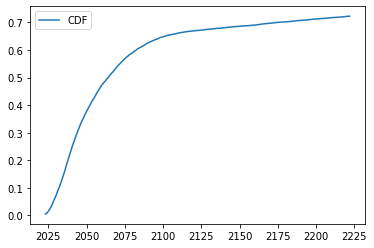

In [62]:
tai_years_ = np.array([MAX_YEAR + 1 if t > MAX_YEAR else t for t in tai_years])
count, bins_count = np.histogram(tai_years_, bins=(MAX_YEAR - CURRENT_YEAR))
pdf = count / sum(count)
cdf = np.cumsum(pdf)
bins = np.round(np.array([b for b in bins_count[1:] if b <= MAX_YEAR]))

plt.plot(bins, cdf[:len(bins)], label='CDF')
plt.legend()

<string>:73: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<string>:74: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#dep

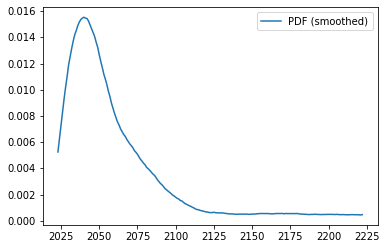

In [63]:
pdf_smoothed = savitzky_golay(pdf[:len(bins)], 51, 3) # window size 51, polynomial order 3
plt.plot(bins, pdf_smoothed, label='PDF (smoothed)')
plt.legend()
plt.show()

In [64]:
cdf[:len(bins)]

array([0.0055, 0.0082, 0.0152, 0.0236, 0.0335, 0.0471, 0.0598, 0.0718,
       0.0872, 0.1002, 0.1161, 0.1319, 0.1492, 0.1662, 0.1859, 0.2036,
       0.2216, 0.2391, 0.2574, 0.2717, 0.2875, 0.3024, 0.3168, 0.3309,
       0.3428, 0.3554, 0.367 , 0.3773, 0.3871, 0.3982, 0.4085, 0.4189,
       0.4266, 0.4373, 0.4471, 0.4559, 0.4645, 0.4735, 0.4802, 0.4862,
       0.4933, 0.4999, 0.5075, 0.514 , 0.5195, 0.5266, 0.5332, 0.5401,
       0.5461, 0.5515, 0.5577, 0.5627, 0.5681, 0.574 , 0.5778, 0.5832,
       0.5867, 0.59  , 0.5946, 0.5983, 0.6028, 0.6062, 0.6091, 0.6124,
       0.6155, 0.6184, 0.6226, 0.625 , 0.6281, 0.6307, 0.6328, 0.6353,
       0.6381, 0.6397, 0.6422, 0.6453, 0.6465, 0.648 , 0.6501, 0.6518,
       0.6531, 0.6548, 0.6559, 0.6567, 0.6579, 0.6586, 0.6602, 0.6616,
       0.6625, 0.6632, 0.6646, 0.6657, 0.6664, 0.6669, 0.6677, 0.6686,
       0.6691, 0.6696, 0.6701, 0.6709, 0.672 , 0.6723, 0.6728, 0.6736,
       0.6743, 0.6752, 0.6753, 0.676 , 0.6765, 0.677 , 0.6775, 0.6785,
      

In [65]:
pdf[:len(bins)]

array([0.0055, 0.0027, 0.007 , 0.0084, 0.0099, 0.0136, 0.0127, 0.012 ,
       0.0154, 0.013 , 0.0159, 0.0158, 0.0173, 0.017 , 0.0197, 0.0177,
       0.018 , 0.0175, 0.0183, 0.0143, 0.0158, 0.0149, 0.0144, 0.0141,
       0.0119, 0.0126, 0.0116, 0.0103, 0.0098, 0.0111, 0.0103, 0.0104,
       0.0077, 0.0107, 0.0098, 0.0088, 0.0086, 0.009 , 0.0067, 0.006 ,
       0.0071, 0.0066, 0.0076, 0.0065, 0.0055, 0.0071, 0.0066, 0.0069,
       0.006 , 0.0054, 0.0062, 0.005 , 0.0054, 0.0059, 0.0038, 0.0054,
       0.0035, 0.0033, 0.0046, 0.0037, 0.0045, 0.0034, 0.0029, 0.0033,
       0.0031, 0.0029, 0.0042, 0.0024, 0.0031, 0.0026, 0.0021, 0.0025,
       0.0028, 0.0016, 0.0025, 0.0031, 0.0012, 0.0015, 0.0021, 0.0017,
       0.0013, 0.0017, 0.0011, 0.0008, 0.0012, 0.0007, 0.0016, 0.0014,
       0.0009, 0.0007, 0.0014, 0.0011, 0.0007, 0.0005, 0.0008, 0.0009,
       0.0005, 0.0005, 0.0005, 0.0008, 0.0011, 0.0003, 0.0005, 0.0008,
       0.0007, 0.0009, 0.0001, 0.0007, 0.0005, 0.0005, 0.0005, 0.001 ,
      

In [66]:
d_ = dict(zip(years, cdf[:len(bins)]))
print('2020-2029: {}%'.format(round(d_[2029] * 100)))
print('2030-2039: {}%'.format(round((d_[2039] - d_[2029]) * 100)))
print('2040-2049: {}%'.format(round((d_[2049] - d_[2039]) * 100)))
print('2050-2059: {}%'.format(round((d_[2059] - d_[2049]) * 100)))
print('2060-2069: {}%'.format(round((d_[2069] - d_[2059]) * 100)))
print('2070-2099: {}%'.format(round((d_[2099] - d_[2069]) * 100)))
print('2100-2199: {}%'.format(round((d_[2199] - d_[2099]) * 100)))
print('>2200: {}%'.format(round((1 - d_[2199]) * 100)))

2020-2029: 7%
2030-2039: 17%
2040-2049: 14%
2050-2059: 10%
2060-2069: 7%
2070-2099: 11%
2100-2199: 7%
>2200: 29%


<string>:73: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<string>:74: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#dep

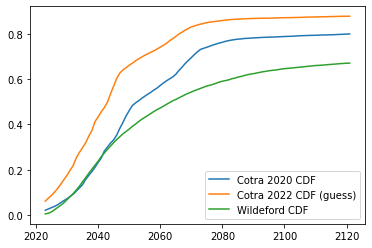

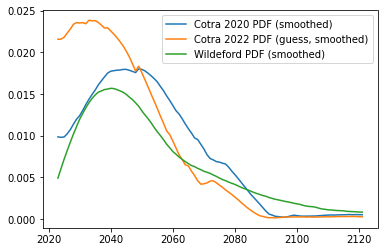

In [67]:
## TODO: Update all

cotra_2020_cdf = [0.0214, 0.0272, 0.0328, 0.0385, 0.0458, 0.0551, 0.0641, 0.0721,
       0.0827, 0.0923, 0.1061, 0.1199, 0.1343, 0.1574, 0.175 , 0.1917,
       0.2108, 0.2321, 0.251 , 0.2825, 0.3001, 0.3177, 0.3317, 0.3531,
       0.3829, 0.4089, 0.4372, 0.4606, 0.4829, 0.4944, 0.504 , 0.5147,
       0.5243, 0.5335, 0.5423, 0.5521, 0.5608, 0.5719, 0.5826, 0.5922,
       0.6011, 0.6096, 0.6209, 0.6379, 0.6524, 0.6682, 0.682 , 0.6948,
       0.7084, 0.7207, 0.7314, 0.7362, 0.7407, 0.7456, 0.7506, 0.755 ,
       0.7594, 0.7626, 0.7668, 0.7698, 0.7725, 0.7745, 0.7765, 0.7775,
       0.7793, 0.7801, 0.781 , 0.7818, 0.7827, 0.7833, 0.7843, 0.7847,
       0.7852, 0.7858, 0.7861, 0.7868, 0.7874, 0.7882, 0.7887, 0.7891,
       0.7895, 0.7908, 0.7916, 0.7918, 0.7926, 0.7929, 0.7933, 0.7936,
       0.7941, 0.7949, 0.795 , 0.7954, 0.7957, 0.7962, 0.7969, 0.7976,
       0.7981, 0.7987, 0.7996, 0.8002, 0.8004, 0.801 , 0.8015, 0.8021,
       0.8025, 0.8029, 0.8034, 0.8041, 0.8045, 0.8052, 0.8059, 0.806 ,
       0.8066, 0.8071, 0.8079, 0.8087, 0.8089, 0.8093, 0.8093, 0.8095,
       0.8105, 0.8109, 0.8114, 0.8118, 0.8128, 0.8132, 0.8139, 0.8139,
       0.8144, 0.8149, 0.8154, 0.8162, 0.8167, 0.8173, 0.8177, 0.8185,
       0.8196, 0.82  , 0.821 , 0.8217, 0.8224, 0.8233, 0.8244, 0.8247,
       0.8254, 0.8262, 0.8267, 0.8274, 0.8277, 0.8288, 0.8294, 0.8298,
       0.8305, 0.8318, 0.8328, 0.8335, 0.8343, 0.8347, 0.8351, 0.8361,
       0.837 , 0.8376, 0.8385, 0.8398, 0.8404, 0.8413, 0.8419, 0.8427,
       0.8437, 0.8448, 0.8458, 0.8462, 0.8471, 0.8482, 0.8487, 0.8491,
       0.8498, 0.8505, 0.8507, 0.8511, 0.8519, 0.8526, 0.8534, 0.8542,
       0.855 , 0.8554, 0.8559, 0.8565, 0.857 , 0.8575, 0.8581, 0.8587,
       0.8592, 0.86  , 0.8605, 0.861 , 0.8615, 0.862 , 0.8629]
cotra_2020_pdf = np.append(np.array(cotra_2020_cdf[0]), np.diff(cotra_2020_cdf[:len(bins)]))
cotra_2020_pdf_smoothed = savitzky_golay(cotra_2020_pdf[:len(bins)], 51, 3)

cotra_2022_cdf = [0.0616, 0.0747, 0.0873, 0.1015, 0.118 , 0.1365, 0.1564, 0.1758,
       0.1981, 0.2188, 0.2531, 0.2768, 0.2975, 0.3193, 0.3481, 0.3728,
       0.4124, 0.433 , 0.4557, 0.4742, 0.4981, 0.5348, 0.569 , 0.6032,
       0.627 , 0.6404, 0.6507, 0.6611, 0.6701, 0.6801, 0.6893, 0.697 ,
       0.7051, 0.7115, 0.7186, 0.7252, 0.7331, 0.7411, 0.749 , 0.7577,
       0.7691, 0.7785, 0.7881, 0.799 , 0.807 , 0.8161, 0.8233, 0.8303,
       0.8348, 0.839 , 0.8429, 0.8462, 0.8494, 0.8517, 0.8532, 0.8553,
       0.8566, 0.8588, 0.8602, 0.862 , 0.8633, 0.864 , 0.8648, 0.8654,
       0.8662, 0.867 , 0.8672, 0.8677, 0.8683, 0.8686, 0.8689, 0.8689,
       0.8692, 0.8695, 0.8699, 0.8703, 0.8709, 0.8711, 0.8713, 0.8715,
       0.8719, 0.8721, 0.8727, 0.873 , 0.8736, 0.8739, 0.8742, 0.8746,
       0.875 , 0.8751, 0.8754, 0.8757, 0.8763, 0.8764, 0.8768, 0.8772,
       0.8775, 0.8775, 0.8776, 0.8779, 0.878 , 0.8781, 0.8783, 0.8789,
       0.8792, 0.8794, 0.8795, 0.8798, 0.8805, 0.8808, 0.8814, 0.8819,
       0.8822, 0.8826, 0.8827, 0.8828, 0.8832, 0.8834, 0.8837, 0.8839,
       0.8842, 0.8848, 0.8857, 0.8859, 0.8861, 0.8863, 0.8866, 0.8869,
       0.8869, 0.8873, 0.8878, 0.8889, 0.8896, 0.8904, 0.8906, 0.8911,
       0.8915, 0.892 , 0.8929, 0.8934, 0.8937, 0.8942, 0.8946, 0.8954,
       0.8959, 0.8963, 0.8969, 0.8972, 0.8975, 0.8984, 0.8988, 0.8993,
       0.8999, 0.9004, 0.9007, 0.9015, 0.9019, 0.9021, 0.9026, 0.9031,
       0.9037, 0.9041, 0.9048, 0.9054, 0.9057, 0.9062, 0.9067, 0.9075,
       0.9084, 0.9088, 0.909 , 0.9101, 0.9106, 0.9108, 0.9114, 0.9116,
       0.9121, 0.9127, 0.913 , 0.9137, 0.9144, 0.9147, 0.9154, 0.9159,
       0.9161, 0.9166, 0.9173, 0.9177, 0.9185, 0.9189, 0.9193, 0.9195,
       0.9195, 0.9198, 0.9204, 0.9205, 0.921 , 0.9216, 0.9221]
cotra_2022_pdf = np.append(np.array(cotra_2022_cdf[0]), np.diff(cotra_2022_cdf[:len(bins)]))
cotra_2022_pdf_smoothed = savitzky_golay(cotra_2022_pdf[:len(bins)], 51, 3)

peter_cdf = [0.0051, 0.0081, 0.0141, 0.0236, 0.0337, 0.0433, 0.0545, 0.0679,
       0.0814, 0.0949, 0.111 , 0.1275, 0.147 , 0.1651, 0.1843, 0.2024,
       0.2199, 0.2374, 0.2574, 0.2736, 0.2898, 0.3042, 0.3198, 0.3335,
       0.3459, 0.3585, 0.3688, 0.3793, 0.3909, 0.401 , 0.4119, 0.4222,
       0.4309, 0.4395, 0.4484, 0.4575, 0.4655, 0.4726, 0.4803, 0.4886,
       0.4961, 0.5041, 0.5102, 0.5172, 0.5241, 0.5311, 0.5375, 0.5429,
       0.549 , 0.5543, 0.5592, 0.5644, 0.5697, 0.5731, 0.577 , 0.582 ,
       0.5869, 0.5908, 0.5935, 0.5968, 0.6014, 0.6043, 0.6087, 0.6119,
       0.6156, 0.6191, 0.6221, 0.6241, 0.6268, 0.6297, 0.6324, 0.6345,
       0.6369, 0.6387, 0.6399, 0.642 , 0.6445, 0.6461, 0.6475, 0.6488,
       0.6501, 0.6516, 0.6529, 0.6542, 0.6559, 0.6571, 0.6587, 0.66  ,
       0.6607, 0.6616, 0.6626, 0.6641, 0.6649, 0.6662, 0.6672, 0.6685,
       0.6693, 0.6703, 0.6707, 0.6712, 0.6719, 0.6726, 0.6732, 0.6742,
       0.6751, 0.6755, 0.676 , 0.676 , 0.6764, 0.6775, 0.6788, 0.6798,
       0.6803, 0.6807, 0.6812, 0.682 , 0.6824, 0.6828, 0.6835, 0.6838,
       0.6845, 0.6852, 0.6859, 0.6862, 0.6867, 0.6872, 0.688 , 0.6886,
       0.689 , 0.6892, 0.6901, 0.6906, 0.6913, 0.692 , 0.6926, 0.6934,
       0.6943, 0.6952, 0.6956, 0.6963, 0.6966, 0.6974, 0.698 , 0.6985,
       0.699 , 0.6994, 0.7001, 0.7008, 0.7013, 0.702 , 0.7027, 0.7029,
       0.7032, 0.704 , 0.7042, 0.705 , 0.7054, 0.7057, 0.7067, 0.7069,
       0.7076, 0.7078, 0.7085, 0.7088, 0.7096, 0.7105, 0.711 , 0.7117,
       0.7121, 0.7126, 0.7133, 0.7139, 0.7148, 0.7148, 0.7154, 0.7164,
       0.7166, 0.7172, 0.7175, 0.718 , 0.7183, 0.7189, 0.7195, 0.7197,
       0.7203, 0.7209, 0.7215, 0.722 , 0.7227, 0.723 , 0.7236, 0.7241,
       0.7246, 0.7253, 0.7259, 0.7263, 0.7266, 0.7275, 0.7277]
peter_pdf = np.append(np.array(peter_cdf[0]), np.diff(peter_cdf[:len(bins)]))
peter_pdf_smoothed = savitzky_golay(peter_pdf[:len(bins)], 51, 3)

plt.plot(bins[:99], cotra_2020_cdf[:99], label='Cotra 2020 CDF')
plt.plot(bins[:99], cotra_2022_cdf[:99], label='Cotra 2022 CDF (guess)')
plt.plot(bins[:99], peter_cdf[:99], label='Wildeford CDF')
plt.legend()
plt.show()

plt.plot(bins[:99], cotra_2020_pdf_smoothed[:99], label='Cotra 2020 PDF (smoothed)')
plt.plot(bins[:99], cotra_2022_pdf_smoothed[:99], label='Cotra 2022 PDF (guess, smoothed)')
plt.plot(bins[:99], peter_pdf_smoothed[:99], label='Wildeford PDF (smoothed)')
plt.legend()
plt.show()

## Sensitivity Analysis

In [68]:
print('## Default ##')
results = sq.sample(lambda: run_model(initial_gdp_=21*T,
                                      tai_flop_size_=36,
                                      nonscaling_delay_=0,
                                      algo_doubling_rate_=2,
                                      possible_algo_reduction_=2,
                                      initial_flops_per_dollar_=10 ** 18,
                                      flops_halving_rate_=2.5,
                                      max_flops_per_dollar_=10 ** 24,
                                      initial_pay_=10*M,
                                      gdp_growth_=1.03,
                                      max_gdp_frac_=1/100,
                                      willingness_ramp_=1,
                                      spend_doubling_time_=2.5,
                                      initial_chance_of_nonscaling_issue_=0,
                                      final_chance_of_nonscaling_issue_=0,
                                      nonscaling_issue_bottom_year_=0,
                                      willingness_spend_horizon_=1,
                                      print_diagnostic=False), n=1000)
print('{}: {}'.format(t,
                      ['>2222' if int(sq.get_percentiles(results)[5]) > 2222 else int(sq.get_percentiles(results)[5]),
                       '>2222' if int(sq.get_percentiles(results)[50]) > 2222 else int(sq.get_percentiles(results)[50]),
                       '>2222' if int(sq.get_percentiles(results)[95]) > 2222 else int(sq.get_percentiles(results)[95])]))
          

## Default ##
59: [2061, 2061, 2061]


In [75]:
print('## Horizon Length ##')
for t in range(0, 10):
    results = sq.sample(lambda: run_model(initial_gdp_=21*T,
                                          tai_flop_size_=sample_cotra_anchor(horizon_length=sq.const(t)),
                                          nonscaling_delay_=0,
                                          algo_doubling_rate_=2,
                                          possible_algo_reduction_=2,
                                          initial_flops_per_dollar_=10 ** 18,
                                          flops_halving_rate_=2.5,
                                          max_flops_per_dollar_=10 ** 24,
                                          initial_pay_=10*M,
                                          gdp_growth_=1.03,
                                          max_gdp_frac_=1/100,
                                          willingness_ramp_=1,
                                          spend_doubling_time_=2.5,
                                          initial_chance_of_nonscaling_issue_=0,
                                          final_chance_of_nonscaling_issue_=0,
                                          nonscaling_issue_bottom_year_=0,
                                          willingness_spend_horizon_=1,
                                          print_diagnostic=False), n=1000)
    print('{}: {}'.format(t,
                          ['>2222' if int(sq.get_percentiles(results)[5]) > 2222 else int(sq.get_percentiles(results)[5]),
                           '>2222' if int(sq.get_percentiles(results)[50]) > 2222 else int(sq.get_percentiles(results)[50]),
                           '>2222' if int(sq.get_percentiles(results)[95]) > 2222 else int(sq.get_percentiles(results)[95])]))
          

## Horizon Length ##
0: [2025, 2038, 2164]
1: [2027, 2040, 2218]
2: [2027, 2043, '>2222']
3: [2028, 2046, '>2222']
4: [2029, 2051, '>2222']
5: [2033, 2057, '>2222']
6: [2033, 2060, '>2222']
7: [2036, 2067, '>2222']
8: [2040, 2080, '>2222']
9: [2044, 2143, '>2222']


In [ ]:
print('## Horizon Length - no Bayes Update ##')
for t in range(0, 10):
    results = sq.sample(lambda: run_model(initial_gdp_=21*T,
                                          tai_flop_size_=sample_cotra_anchor(horizon_length=sq.const(t),
                                                                             bayes_update=None),
                                          nonscaling_delay_=0,
                                          algo_doubling_rate_=2,
                                          possible_algo_reduction_=2,
                                          initial_flops_per_dollar_=10 ** 18,
                                          flops_halving_rate_=2.5,
                                          max_flops_per_dollar_=10 ** 24,
                                          initial_pay_=10*M,
                                          gdp_growth_=1.03,
                                          max_gdp_frac_=1/100,
                                          willingness_ramp_=1,
                                          spend_doubling_time_=2.5,
                                          initial_chance_of_nonscaling_issue_=0,
                                          final_chance_of_nonscaling_issue_=0,
                                          nonscaling_issue_bottom_year_=0,
                                          willingness_spend_horizon_=1,
                                          print_diagnostic=False), n=1000)
    print('{}: {}'.format(t,
                          ['>2222' if int(sq.get_percentiles(results)[5]) > 2222 else int(sq.get_percentiles(results)[5]),
                           '>2222' if int(sq.get_percentiles(results)[50]) > 2222 else int(sq.get_percentiles(results)[50]),
                           '>2222' if int(sq.get_percentiles(results)[95]) > 2222 else int(sq.get_percentiles(results)[95])]))
          

In [ ]:
print('## TAI FLOP Size ##')
for t in range(20, 51):
    results = sq.sample(lambda: run_model(initial_gdp_=21*T,
                                          tai_flop_size_=t,
                                          nonscaling_delay_=0,
                                          algo_doubling_rate_=2,
                                          possible_algo_reduction_=2,
                                          initial_flops_per_dollar_=10 ** 18,
                                          flops_halving_rate_=2.5,
                                          max_flops_per_dollar_=10 ** 24,
                                          initial_pay_=10*M,
                                          gdp_growth_=1.03,
                                          max_gdp_frac_=1/100,
                                          willingness_ramp_=1,
                                          spend_doubling_time_=2.5,
                                          initial_chance_of_nonscaling_issue_=0,
                                          final_chance_of_nonscaling_issue_=0,
                                          nonscaling_issue_bottom_year_=0,
                                          willingness_spend_horizon_=1,
                                          print_diagnostic=False), n=1000)
    print('{}: {}'.format(t,
                          ['>2222' if int(sq.get_percentiles(results)[5]) > 2222 else int(sq.get_percentiles(results)[5]),
                           '>2222' if int(sq.get_percentiles(results)[50]) > 2222 else int(sq.get_percentiles(results)[50]),
                           '>2222' if int(sq.get_percentiles(results)[95]) > 2222 else int(sq.get_percentiles(results)[95])]))
    

In [ ]:
print('## GDP Growth ##')
for g in range(0, 5):
    results = sq.sample(lambda: run_model(initial_gdp_=21*T,
                                          tai_flop_size_=36,
                                          nonscaling_delay_=0,
                                          algo_doubling_rate_=2,
                                          possible_algo_reduction_=2,
                                          initial_flops_per_dollar_=10 ** 18,
                                          flops_halving_rate_=2.5,
                                          max_flops_per_dollar_=10 ** 24,
                                          initial_pay_=10*M,
                                          gdp_growth_=1 + g/100,
                                          max_gdp_frac_=1/100,
                                          willingness_ramp_=1,
                                          spend_doubling_time_=2.5,
                                          initial_chance_of_nonscaling_issue_=0,
                                          final_chance_of_nonscaling_issue_=0,
                                          nonscaling_issue_bottom_year_=0,
                                          willingness_spend_horizon_=1,
                                          print_diagnostic=False), n=1000)
    print('{}: {}'.format(1 + g / 100,
                          ['>2222' if int(sq.get_percentiles(results)[5]) > 2222 else int(sq.get_percentiles(results)[5]),
                           '>2222' if int(sq.get_percentiles(results)[50]) > 2222 else int(sq.get_percentiles(results)[50]),
                           '>2222' if int(sq.get_percentiles(results)[95]) > 2222 else int(sq.get_percentiles(results)[95])]))
    

In [ ]:
print('## Max GDP Frac ##')
for g in [1/(10*K),5/(10*K), 1/1000, 2/1000, 3/1000, 4/1000, 5/1000, 1/100, 2/100]:
    results = sq.sample(lambda: run_model(initial_gdp_=21*T,
                                          tai_flop_size_=36,
                                          nonscaling_delay_=0,
                                          algo_doubling_rate_=2,
                                          possible_algo_reduction_=2,
                                          initial_flops_per_dollar_=10 ** 18,
                                          flops_halving_rate_=2.5,
                                          max_flops_per_dollar_=10 ** 24,
                                          initial_pay_=10*M,
                                          gdp_growth_=1.03,
                                          max_gdp_frac_=g,
                                          willingness_ramp_=1,
                                          spend_doubling_time_=2.5,
                                          initial_chance_of_nonscaling_issue_=0,
                                          final_chance_of_nonscaling_issue_=0,
                                          nonscaling_issue_bottom_year_=0,
                                          willingness_spend_horizon_=1,
                                          print_diagnostic=False), n=1000)
    print('{}: {}'.format(g,
                          ['>2222' if int(sq.get_percentiles(results)[5]) > 2222 else int(sq.get_percentiles(results)[5]),
                           '>2222' if int(sq.get_percentiles(results)[50]) > 2222 else int(sq.get_percentiles(results)[50]),
                           '>2222' if int(sq.get_percentiles(results)[95]) > 2222 else int(sq.get_percentiles(results)[95])]))
    

In [ ]:
print('## Spend Doubling Time ##')
for d in range(0, 50):
    results = sq.sample(lambda: run_model(initial_gdp_=21*T,
                                          tai_flop_size_=36,
                                          nonscaling_delay_=0,
                                          algo_doubling_rate_=2,
                                          possible_algo_reduction_=2,
                                          initial_flops_per_dollar_=10 ** 18,
                                          flops_halving_rate_=2.5,
                                          max_flops_per_dollar_=10 ** 24,
                                          initial_pay_=10*M,
                                          gdp_growth_=1.03,
                                          max_gdp_frac_=1/100,
                                          willingness_ramp_=1,
                                          spend_doubling_time_=1 + d / 10,
                                          initial_chance_of_nonscaling_issue_=0,
                                          final_chance_of_nonscaling_issue_=0,
                                          nonscaling_issue_bottom_year_=0,
                                          willingness_spend_horizon_=1,
                                          print_diagnostic=False), n=1000)
    print('{}: {}'.format(1 + d / 10,
                          ['>2222' if int(sq.get_percentiles(results)[5]) > 2222 else int(sq.get_percentiles(results)[5]),
                           '>2222' if int(sq.get_percentiles(results)[50]) > 2222 else int(sq.get_percentiles(results)[50]),
                           '>2222' if int(sq.get_percentiles(results)[95]) > 2222 else int(sq.get_percentiles(results)[95])]))
    

In [ ]:
print('## Initial FLOPs per dollar ##')
for d in [17, 17.5, 18]:
    results = sq.sample(lambda: run_model(initial_gdp_=21*T,
                                          tai_flop_size_=36,
                                          nonscaling_delay_=0,
                                          algo_doubling_rate_=2,
                                          possible_algo_reduction_=2,
                                          initial_flops_per_dollar_=10 ** d,
                                          flops_halving_rate_=2.5,
                                          max_flops_per_dollar_=10 ** 24,
                                          initial_pay_=10*M,
                                          gdp_growth_=1.03,
                                          max_gdp_frac_=1/100,
                                          willingness_ramp_=1,
                                          spend_doubling_time_=2.5,
                                          initial_chance_of_nonscaling_issue_=0,
                                          final_chance_of_nonscaling_issue_=0,
                                          nonscaling_issue_bottom_year_=0,
                                          willingness_spend_horizon_=1,
                                          print_diagnostic=False), n=1000)
    print('{}: {}'.format(d,
                          ['>2222' if int(sq.get_percentiles(results)[5]) > 2222 else int(sq.get_percentiles(results)[5]),
                           '>2222' if int(sq.get_percentiles(results)[50]) > 2222 else int(sq.get_percentiles(results)[50]),
                           '>2222' if int(sq.get_percentiles(results)[95]) > 2222 else int(sq.get_percentiles(results)[95])]))
    

In [ ]:
print('## Initial pay ##')
for p in range(70, 91):
    results = sq.sample(lambda: run_model(initial_gdp_=21*T,
                                          tai_flop_size_=36,
                                          nonscaling_delay_=0,
                                          algo_doubling_rate_=2,
                                          possible_algo_reduction_=2,
                                          initial_flops_per_dollar_=10 ** 18,
                                          flops_halving_rate_=2.5,
                                          max_flops_per_dollar_=10 ** 24,
                                          initial_pay_=10 ** (p / 10),
                                          gdp_growth_=1.03,
                                          max_gdp_frac_=1/100,
                                          willingness_ramp_=1,
                                          spend_doubling_time_=2.5,
                                          initial_chance_of_nonscaling_issue_=0,
                                          final_chance_of_nonscaling_issue_=0,
                                          nonscaling_issue_bottom_year_=0,
                                          willingness_spend_horizon_=1,
                                          print_diagnostic=False), n=1000)
    print('{}: {}'.format(10 ** (p / 10),
                          ['>2222' if int(sq.get_percentiles(results)[5]) > 2222 else int(sq.get_percentiles(results)[5]),
                           '>2222' if int(sq.get_percentiles(results)[50]) > 2222 else int(sq.get_percentiles(results)[50]),
                           '>2222' if int(sq.get_percentiles(results)[95]) > 2222 else int(sq.get_percentiles(results)[95])]))
    

In [ ]:
print('## FLOPs halving rate ##')
for f in range(5, 41):
    results = sq.sample(lambda: run_model(initial_gdp_=21*T,
                                          tai_flop_size_=36,
                                          nonscaling_delay_=0,
                                          algo_doubling_rate_=2,
                                          possible_algo_reduction_=2,
                                          initial_flops_per_dollar_=10 ** 18,
                                          flops_halving_rate_=f / 10,
                                          max_flops_per_dollar_=10 ** 24,
                                          initial_pay_=10*M,
                                          gdp_growth_=1.03,
                                          max_gdp_frac_=1/100,
                                          willingness_ramp_=1,
                                          spend_doubling_time_=2.5,
                                          initial_chance_of_nonscaling_issue_=0,
                                          final_chance_of_nonscaling_issue_=0,
                                          nonscaling_issue_bottom_year_=0,
                                          willingness_spend_horizon_=1,
                                          print_diagnostic=False), n=1000)
    print('{}: {}'.format(f / 10,
                          ['>2222' if int(sq.get_percentiles(results)[5]) > 2222 else int(sq.get_percentiles(results)[5]),
                           '>2222' if int(sq.get_percentiles(results)[50]) > 2222 else int(sq.get_percentiles(results)[50]),
                           '>2222' if int(sq.get_percentiles(results)[95]) > 2222 else int(sq.get_percentiles(results)[95])]))
    

In [ ]:
print('## Max FLOPs per dollar ##')
for f in range(20, 31):
    results = sq.sample(lambda: run_model(initial_gdp_=21*T,
                                          tai_flop_size_=36,
                                          nonscaling_delay_=0,
                                          algo_doubling_rate_=2,
                                          possible_algo_reduction_=2,
                                          initial_flops_per_dollar_=10 ** 18,
                                          flops_halving_rate_=2.5,
                                          max_flops_per_dollar_=10 ** f,
                                          initial_pay_=10*M,
                                          gdp_growth_=1.03,
                                          max_gdp_frac_=1/100,
                                          willingness_ramp_=1,
                                          spend_doubling_time_=2.5,
                                          initial_chance_of_nonscaling_issue_=0,
                                          final_chance_of_nonscaling_issue_=0,
                                          nonscaling_issue_bottom_year_=0,
                                          willingness_spend_horizon_=1,
                                          print_diagnostic=False), n=1000)
    print('{}: {}'.format(f,
                          ['>2222' if int(sq.get_percentiles(results)[5]) > 2222 else int(sq.get_percentiles(results)[5]),
                           '>2222' if int(sq.get_percentiles(results)[50]) > 2222 else int(sq.get_percentiles(results)[50]),
                           '>2222' if int(sq.get_percentiles(results)[95]) > 2222 else int(sq.get_percentiles(results)[95])]))
    

In [ ]:
print('## Willingness ramp ##')
for r in range(1, 11):
    results = sq.sample(lambda: run_model(initial_gdp_=21*T,
                                          tai_flop_size_=36,
                                          nonscaling_delay_=0,
                                          algo_doubling_rate_=2,
                                          possible_algo_reduction_=2,
                                          initial_flops_per_dollar_=10 ** 18,
                                          flops_halving_rate_=2.5,
                                          max_flops_per_dollar_=10 ** 24,
                                          initial_pay_=10*M,
                                          gdp_growth_=1.03,
                                          max_gdp_frac_=1/100,
                                          willingness_ramp_=r / 10,
                                          spend_doubling_time_=2.5,
                                          initial_chance_of_nonscaling_issue_=0,
                                          final_chance_of_nonscaling_issue_=0,
                                          nonscaling_issue_bottom_year_=0,
                                          willingness_spend_horizon_=1,
                                          print_diagnostic=False), n=1000)
    print('{}: {}'.format(r / 10,
                          ['>2222' if int(sq.get_percentiles(results)[5]) > 2222 else int(sq.get_percentiles(results)[5]),
                           '>2222' if int(sq.get_percentiles(results)[50]) > 2222 else int(sq.get_percentiles(results)[50]),
                           '>2222' if int(sq.get_percentiles(results)[95]) > 2222 else int(sq.get_percentiles(results)[95])]))
    

In [ ]:
print('## Willingness to spend horizon ##')
for y in range(1, 11):
    results = sq.sample(lambda: run_model(initial_gdp_=21*T,
                                          tai_flop_size_=36,
                                          nonscaling_delay_=0,
                                          algo_doubling_rate_=2,
                                          possible_algo_reduction_=2,
                                          initial_flops_per_dollar_=10 ** 18,
                                          flops_halving_rate_=2.5,
                                          max_flops_per_dollar_=10 ** 24,
                                          initial_pay_=10*M,
                                          gdp_growth_=1.03,
                                          max_gdp_frac_=1/100,
                                          willingness_ramp_=1,
                                          spend_doubling_time_=2.5,
                                          initial_chance_of_nonscaling_issue_=0,
                                          final_chance_of_nonscaling_issue_=0,
                                          nonscaling_issue_bottom_year_=0,
                                          willingness_spend_horizon_=y,
                                          print_diagnostic=False), n=1000)
    print('{}: {}'.format(y,
                          ['>2222' if int(sq.get_percentiles(results)[5]) > 2222 else int(sq.get_percentiles(results)[5]),
                           '>2222' if int(sq.get_percentiles(results)[50]) > 2222 else int(sq.get_percentiles(results)[50]),
                           '>2222' if int(sq.get_percentiles(results)[95]) > 2222 else int(sq.get_percentiles(results)[95])]))
    

In [ ]:
print('## Algo doubling rate ##')
for d in range(10, 41, 2):
    results = sq.sample(lambda: run_model(initial_gdp_=21*T,
                                          tai_flop_size_=36,
                                          nonscaling_delay_=0,
                                          algo_doubling_rate_=d / 10,
                                          possible_algo_reduction_=2,
                                          initial_flops_per_dollar_=10 ** 18,
                                          flops_halving_rate_=2.5,
                                          max_flops_per_dollar_=10 ** 24,
                                          initial_pay_=10*M,
                                          gdp_growth_=1.03,
                                          max_gdp_frac_=1/100,
                                          willingness_ramp_=1,
                                          spend_doubling_time_=2.5,
                                          initial_chance_of_nonscaling_issue_=0,
                                          final_chance_of_nonscaling_issue_=0,
                                          nonscaling_issue_bottom_year_=0,
                                          willingness_spend_horizon_=y,
                                          print_diagnostic=False), n=1000)
    print('{}: {}'.format(d / 10,
                          ['>2222' if int(sq.get_percentiles(results)[5]) > 2222 else int(sq.get_percentiles(results)[5]),
                           '>2222' if int(sq.get_percentiles(results)[50]) > 2222 else int(sq.get_percentiles(results)[50]),
                           '>2222' if int(sq.get_percentiles(results)[95]) > 2222 else int(sq.get_percentiles(results)[95])]))
    

In [ ]:
print('## Possible algo reduction ##')
for r in range(0, 13):
    results = sq.sample(lambda: run_model(initial_gdp_=21*T,
                                          tai_flop_size_=36,
                                          nonscaling_delay_=0,
                                          algo_doubling_rate_=2,
                                          possible_algo_reduction_=r,
                                          initial_flops_per_dollar_=10 ** 18,
                                          flops_halving_rate_=2.5,
                                          max_flops_per_dollar_=10 ** 24,
                                          initial_pay_=10*M,
                                          gdp_growth_=1.03,
                                          max_gdp_frac_=1/100,
                                          willingness_ramp_=1,
                                          spend_doubling_time_=2.5,
                                          initial_chance_of_nonscaling_issue_=0,
                                          final_chance_of_nonscaling_issue_=0,
                                          nonscaling_issue_bottom_year_=0,
                                          willingness_spend_horizon_=y,
                                          print_diagnostic=False), n=1000)
    print('{}: {}'.format(r,
                          ['>2222' if int(sq.get_percentiles(results)[5]) > 2222 else int(sq.get_percentiles(results)[5]),
                           '>2222' if int(sq.get_percentiles(results)[50]) > 2222 else int(sq.get_percentiles(results)[50]),
                           '>2222' if int(sq.get_percentiles(results)[95]) > 2222 else int(sq.get_percentiles(results)[95])]))
    

In [ ]:
# TODO: Wildeford meta anchor horizon length
# TODO: Wildeford meta anchor efficiency w/ efficiency-based algorithmic reduction
# TODO: efficiency-based algorithmic reduction vs. regular algorithmic reduction

In [94]:
get_question(11558)

('success',
 200,
 {'url': 'https://www.metaculus.com/api2/questions/11558/',
  'page_url': '/questions/11558/maximum-compute-used-in-ai-training/',
  'id': 11558,
  'author': 104161,
  'author_name': 'casens',
  'title': 'What will be the maximum compute (in petaFLOPS-days) ever used in training an AI experiment by the following dates?',
  'title_short': 'Maximum Compute Used in AI Training',
  'group_label': 'Date',
  'resolution': None,
  'created_time': '2022-06-24T19:52:03.009175Z',
  'publish_time': '2021-01-14T17:00:00Z',
  'close_time': '2025-03-14T19:00:00Z',
  'resolve_time': '2030-12-31T23:00:00Z',
  'possibilities': {},
  'scoring': {},
  'type': 'group',
  'user_perms': {'NONE': False,
   'PREDICT': True,
   'RESOLVE': False,
   'COMMENT_READ': True,
   'COMMENT_POST': True,
   'COMMENT_EDIT': True,
   'COMMENT_MOD': True,
   'EDIT_DRAFT_CONTENT': False,
   'EDIT_PENDING_CONTENT': True,
   'EDIT_UPCOMING_CONTENT': True,
   'EDIT_LIVE_CONTENT': False,
   'EDIT_CATEGORIES': 

In [89]:
# https://www.metaculus.com/questions/11558/maximum-compute-used-in-ai-training/
# TODO: Fetch from Metaculus, look side by side
# TODO: Be able to predict back
for y in [2022, 2025, 2030]:
    print('-')
    print('## {} ##'.format(y))
    for i in range(3):
        flops_at_max_ = flops_at_max(initial_gdp=variables['initial_gdp'],
                                     gdp_growth=[1.02, 1.025, 1.03][i],
                                     initial_pay=[10*M, 100*M, 1*B][i],
                                     spend_doubling_time=[1, 2, 3][i],
                                     max_gdp_frac=[1/1000, 4/1000, 1/100][i],
                                     initial_flops_per_dollar=10 ** 18,
                                     max_flops_per_dollar=10 ** 24,
                                     flops_halving_rate=[2, 2.5, 3][i],
                                     year=(y - CURRENT_YEAR))

        print('{}: {} max log FLOPs / ~{} petaFLOP/s-days)'.format(['25th', 'mean', '75th'][i],
                                                                   np.round(np.log10(flops_at_max_), 1),
                                                                   log_flop_to_petaflop_sdays(np.log10(flops_at_max_))))


-
## 2022 ##
25th: 25.0 max log FLOPs / ~115735 petaFLOP/s-days)
mean: 26.0 max log FLOPs / ~1156863 petaFLOP/s-days)
75th: 27.0 max log FLOPs / ~11519978 petaFLOP/s-days)
-
## 2025 ##
25th: 26.4 max log FLOPs / ~2617980 petaFLOP/s-days)
mean: 26.8 max log FLOPs / ~7511576 petaFLOP/s-days)
75th: 27.6 max log FLOPs / ~45901775 petaFLOP/s-days)
-
## 2030 ##
25th: 28.6 max log FLOPs / ~469252934 petaFLOP/s-days)
mean: 28.2 max log FLOPs / ~169133225 petaFLOP/s-days)
75th: 28.6 max log FLOPs / ~455905830 petaFLOP/s-days)
